In [37]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box
# All the images are saved in image_folder
# All the labels are saved in the annotation_csv file
image_folder = 'data'
annotation_csv = 'data/annotation.csv'

from torchvision import transforms


In [38]:
image_folder = 'data'
annotation_csv = 'data/annotation.csv'
# You shouldn't change the unlabeled_scene_index
# The first 106 scenes are unlabeled
unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should devide the labeled_scene_index into two subsets (training and validation)
labeled_scene_index = np.arange(106, 134)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
random.seed(1008)
random.shuffle(labeled_scene_index)
train_idx = labeled_scene_index[:22]
val_idx = labeled_scene_index[22:26]
test_idx = labeled_scene_index[26:]


In [39]:
transform = torchvision.transforms.Compose([
    # transforms.Resize(size=(256,256)),
    transforms.ToTensor(),
#     transforms.Normalize(img_net_mean.tolist(), img_net_std.tolist())
])

BATCH_SIZE=1

train_set = LabeledDataset(image_folder = image_folder,
                                  annotation_file = annotation_csv,
                                  scene_index = train_idx,
                                  transform = transform, 
                                  extra_info = True)

val_set = LabeledDataset(image_folder = image_folder,
                                  annotation_file = annotation_csv,
                                  scene_index = val_idx,
                                  transform = transform, 
                                  extra_info = True)


test_set = LabeledDataset(image_folder = image_folder,
                                  annotation_file = annotation_csv,
                                  scene_index = test_idx,
                                  transform = transform, 
                                  extra_info = True)

train_loader = torch.utils.data.DataLoader(train_set, batch_size =BATCH_SIZE, 
                                           shuffle = True, num_workers =2, 
                                           collate_fn = collate_fn)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = BATCH_SIZE, 
                                         shuffle = True, num_workers =2, 
                                         collate_fn = collate_fn)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = BATCH_SIZE, 
                                         shuffle = True, num_workers =2, 
                                         collate_fn = collate_fn)


In [40]:
data, target, roadmap, extra = iter(train_loader).next()

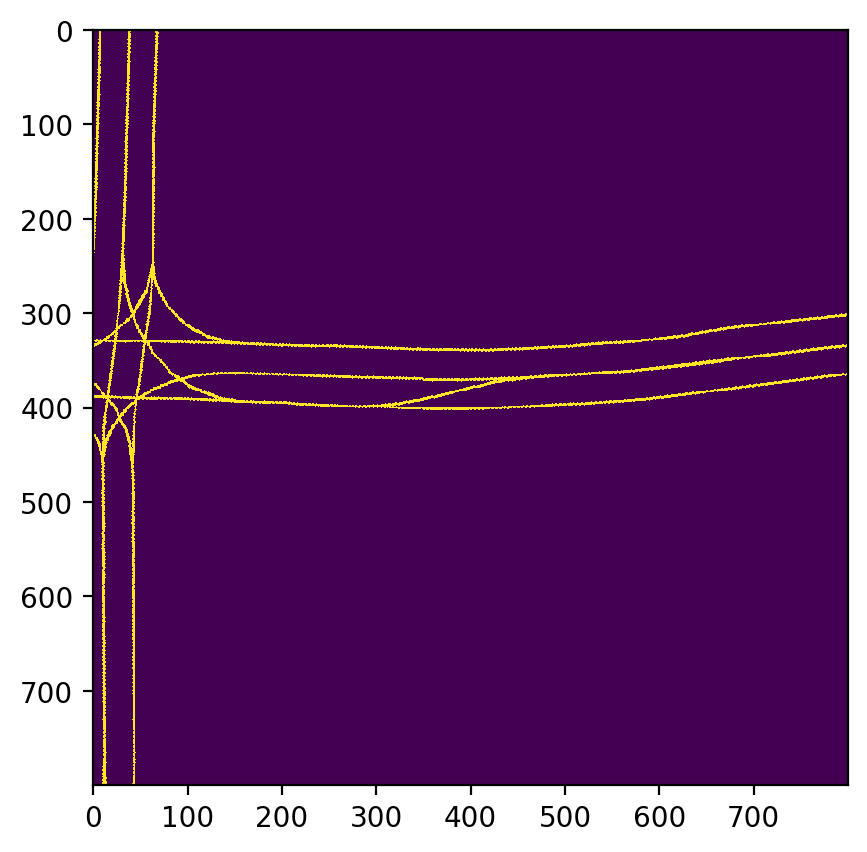

In [41]:
plt.imshow(extra[0]['lane_image'])

In [136]:
def get_upsampling_weight(in_channels, out_channels, kernel_size):
    """Make a 2D bilinear kernel suitable for upsampling"""
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size),
                      dtype=np.float64)
    weight[range(in_channels), range(out_channels), :, :] = filt
    return torch.from_numpy(weight).float()

In [147]:
class encoder_for_vae(nn.Module):

    def __init__(self):
        super(encoder_for_vae, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(2048, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

        self.mu_dec = nn.Linear(18432, 512)
        self.logvar_dec = nn.Linear(18432, 512)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 18432)
        mu = self.mu_dec(x)
        logvar = self.logvar_dec(x)

        return mu, logvar

In [148]:
class _DecoderBlock(nn.Module):
    """
    Taken from https://github.com/zijundeng/pytorch-semantic-segmentation/blob/master/models/seg_net.py
    """
    def __init__(self, in_channels, out_channels, num_conv_layers, out_activation = 'relu'):
        super(_DecoderBlock, self).__init__()
        middle_channels = int(in_channels / 2)
        layers = [
            nn.ConvTranspose2d(in_channels, in_channels, kernel_size=2, stride=2),
            nn.Conv2d(in_channels, middle_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace=True)
        ]
        layers += [
                      nn.Conv2d(middle_channels, middle_channels, kernel_size=3, padding=1),
                      nn.BatchNorm2d(middle_channels),
                      nn.ReLU(inplace=True),
                  ] * (num_conv_layers - 2)
        layers += [
            nn.Conv2d(middle_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True) if out_activation == 'relu' else nn.Sigmoid(),
        ]
        self.decode = nn.Sequential(*layers)

    def forward(self, x):
        return self.decode(x)

In [149]:
class decoder_conv(nn.Module):
    def __init__(self):
        super(decoder_conv, self).__init__()
        self.dec1 = _DecoderBlock(128, 256,2)
        self.dec2 = _DecoderBlock(256, 256,2)
        self.dec3 = _DecoderBlock(256, 256, 2)
        self.dec4 = _DecoderBlock(256, 256, 2)
        self.dec5 = _DecoderBlock(256 ,256, 2)
        self.dec6 = _DecoderBlock(256, 128, 2)
        self.conv_out = nn.Conv2d(128, 1,3 , padding=1)
        self.final_upsample = nn.Upsample((800, 800), mode='bilinear', align_corners=False)
        self.sigmoid = nn.Sigmoid()
        self._initialize_weights()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d):
                assert m.kernel_size[0] == m.kernel_size[1]
                initial_weight = get_upsampling_weight(
                    m.in_channels, m.out_channels, m.kernel_size[0])
                m.weight.data.copy_(initial_weight)
                
    def forward(self, x):
        x = x.view(-1, 128, 2, 2)
        x = self.dec1(x)
        x= self.dec2(x)
        x = self.dec3(x)
        x = self.dec4(x)
        x = self.dec5(x)
        x = self.dec6(x)
        x = self.conv_out(x)
        x = self.final_upsample(x)
        x = self.sigmoid(x)
        return x

In [150]:
class vae_mapping(nn.Module):
    def __init__(self):
        super(vae_mapping, self).__init__()
        
        self.feature_extractor = torchvision.models.resnet50(pretrained = False)
        self.encoder = [nn.Conv2d(1, 64, kernel_size=(7,7), stride=(2,2), padding=(3,3), 
                                 bias = False)] + list(self.feature_extractor.children())[1:-2]
        self.encoder = nn.Sequential(*self.encoder)
        self.encoder_for_vae = encoder_for_vae()
        self.decoder = decoder_conv()
        
    def reparameterize(self, is_training, mu, logvar):
        if is_training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu
        
    def forward(self, x, is_training, defined_mu = None):
        feature_maps = self.encoder(x)
        mu, logvar = self.encoder_for_vae(feature_maps)
        z = self.reparameterize(is_training, mu, logvar)
        
        pred_map = self.decoder(z)
        
        return pred_map, mu, logvar

In [151]:
def dice_loss(true, preds, epsilon = 1e-4):
    #sh1, sh2 = preds.size()
    true = true.view(1, -1)
    preds = preds.view(1, -1)
    prod = torch.sum(true*preds,dim = 1)
    sum_tnp = torch.sum(true + preds, dim = 1)
    num = torch.sum(prod)
    denom = torch.sum(sum_tnp) + epsilon
    loss = 1 - 2*(num/denom)

    return torch.mean(loss)

def dice_loss2(pred,target):
    numerator = 2 * torch.sum(pred * target)
    denominator = torch.sum(pred + target)
    return 1 - (numerator + 1) / (denominator + 1)


def compute_dice(true, preds, epsilon = 1e-7):
    #sh1, sh2 = preds.size()
    true = true.view(1, -1)
    preds = preds.view(1, -1)
    
    prod = torch.sum(true*preds,dim = 1)
    sum_tnp = torch.sum(true + preds, dim = 1)
    
    num = torch.sum(prod)
    denom = torch.sum(sum_tnp) + epsilon

    return torch.mean(num/denom)

def compute_ts_road_map(road_map1, road_map2):
    tp = (road_map1 * road_map2).sum()

    return tp * 1.0 / (road_map1.sum() + road_map2.sum() - tp)

# def loss_function(target, prediction,  mu, logvar):
#     LOSS = dice_loss(target, prediction)
#     KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

#     return 0.9*LOSS + 0.1*KLD



# def loss_function(target, prediction, mu, logvar):
#     #LOSS = dice_loss(target, prediction)
#     LOSS = nn.functional.binary_cross_entropy(target.cpu(), prediction.cpu())
#     KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

#     return 0.9*LOSS + 0.1*KLD

def loss_function(criterion, prediction, target, mu, logvar):
    LOSS = criterion(prediction, target)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return 0.9*LOSS + 0.1*KLD

In [152]:
mini_set, _ = torch.utils.data.random_split(train_set, [5, len(train_set) - 5])
mini_val, _ = torch.utils.data.random_split(val_set, [3, len(val_set)-3])

mini_loader = torch.utils.data.DataLoader(mini_set, batch_size = BATCH_SIZE, 
                                          shuffle = True, num_workers = 2, 
                                          collate_fn = collate_fn)

mini_val_loader = torch.utils.data.DataLoader(mini_val, batch_size = BATCH_SIZE, 
                                          shuffle = True, num_workers = 2, 
                                          collate_fn = collate_fn)

In [164]:
def train_eval_model(model, dataloaders,criterion, loss_function, optimizer, 
                num_epochs, checkpoint, to_save, print_every=10, eval_every = 1, to_eval = False):
    
    start_time = time.time()
    if checkpoint:
        pt = torch.load(checkpoint)
        model.load_state_dict(pt['best_model'])
        optimizer.load_state_dict(pt['optimizer'])
        best_loss = pt['best_loss']
        print('load weights')
    else: 
        best_loss = 1e10
    
    loss_dict = {'train':[], 'val':[]}
    
    for epoch in range(num_epochs):
        epoch_start = time.time()
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-'*10)

        if (to_eval) and (epoch%eval_every == 0):
            phases = ['train', 'val']
        else:
            phases = ['train']
            
        for phase in phases:
            # print(len(dataloaders[phase]))
            
            curr_loss = 0.0
            if phase == 'train':
                model.train()

            else:
                model.eval()
                
            for i, (_, _, _, extra) in enumerate(dataloaders[phase]):
                

                inputs = extra[0]['lane_image'].type(torch.FloatTensor).unsqueeze(0).unsqueeze(0).to(device)
                
                optimizer.zero_grad()
                
                
                if phase == 'train':
                    with torch.set_grad_enabled(phase=='train'):
                        outputs, mu, logvar = model(inputs, is_training=True)
                        loss = loss_function(criterion, outputs.cpu(), inputs.cpu(), mu.cpu(), logvar.cpu())
                        loss.backward()
                        optimizer.step()
                else:
                    with torch.no_grad():
                        outputs, mu, logvar = model(inputs, is_training =False)
                        loss = loss_function(criterion, outputs.cpu(), inputs.cpu(), mu.cpu(), logvar.cpu())
                    

                curr_loss += loss.item()

            
            loss_dict[phase].append(curr_loss/len(dataloaders[phase]))
            # dice_dict[phase].append(curr_dice/len(dataloaders[phase]))
            
            print('current epoch %s composite loss is %f'%(phase, curr_loss))
            #print('current epoch %s dice coef is %f'%(phase, curr_dice))
            print('%sing 1 epoch takes %f'%(phase, time.time() - epoch_start))
            
            if phase == 'val':
                #ts_dict.append(curr_ts/len(dataloaders[phase]))
                #print('current ts is %f'%(curr_ts/len(dataloaders[phase])))
                
                # val: after finishing 1 epoch
                if(curr_loss/len(dataloaders[phase])) < best_loss:
                    print('saving best model')
                    checkpt= {'best_model': model.state_dict(),
                                  'optimizer': optimizer.state_dict(), 
                                  'best_loss': curr_loss/len(dataloaders[phase])}
                    torch.save(checkpt, to_save)
                    best_loss = curr_loss/len(dataloaders[phase])
                                 
        if epoch %print_every == 0:
            print('printing test image')
            fig, ax = plt.subplots(5, 2, figsize=(15,30))
            test_idx = [173, 289, 441, 361, 9]
            for fig_i, i in enumerate(test_idx):
                inputs = val_set[i][-1]['lane_image'].type(torch.FloatTensor).to(device).unsqueeze(0).unsqueeze(0)
                with torch.no_grad():
                    outputs = model(inputs, is_training=False)[0].cpu().squeeze().detach()

                ax[fig_i, 0].imshow(val_set[i][-1]['lane_image'].cpu())

                ax[fig_i, 1].imshow((outputs>0.5).numpy())
            plt.show()
            
    print('This training takes ', time.time() - start_time)
    if to_eval:
        print_phase = ['train', 'val']
    else:
        print_phase = ['train']
    for phase in print_phase:
        fig = plt.figure()
        plt.plot(loss_dict[phase])
        plt.title('%s Loss per epoch'%(phase))
        plt.show()


    
    return model, loss_dict
    

In [154]:
mini_loaders = {'train': mini_loader, 'val': mini_val_loader}
dataloaders = {'train': train_loader, 'val': val_loader}

In [155]:
import time

## After using the new loss fucntion test out result

Epoch 1/20
----------
current epoch train composite loss is 340.080884
training 1 epoch takes 347.583075
current epoch val composite loss is 58.762369
valing 1 epoch takes 385.333757
saving best model
printing test image


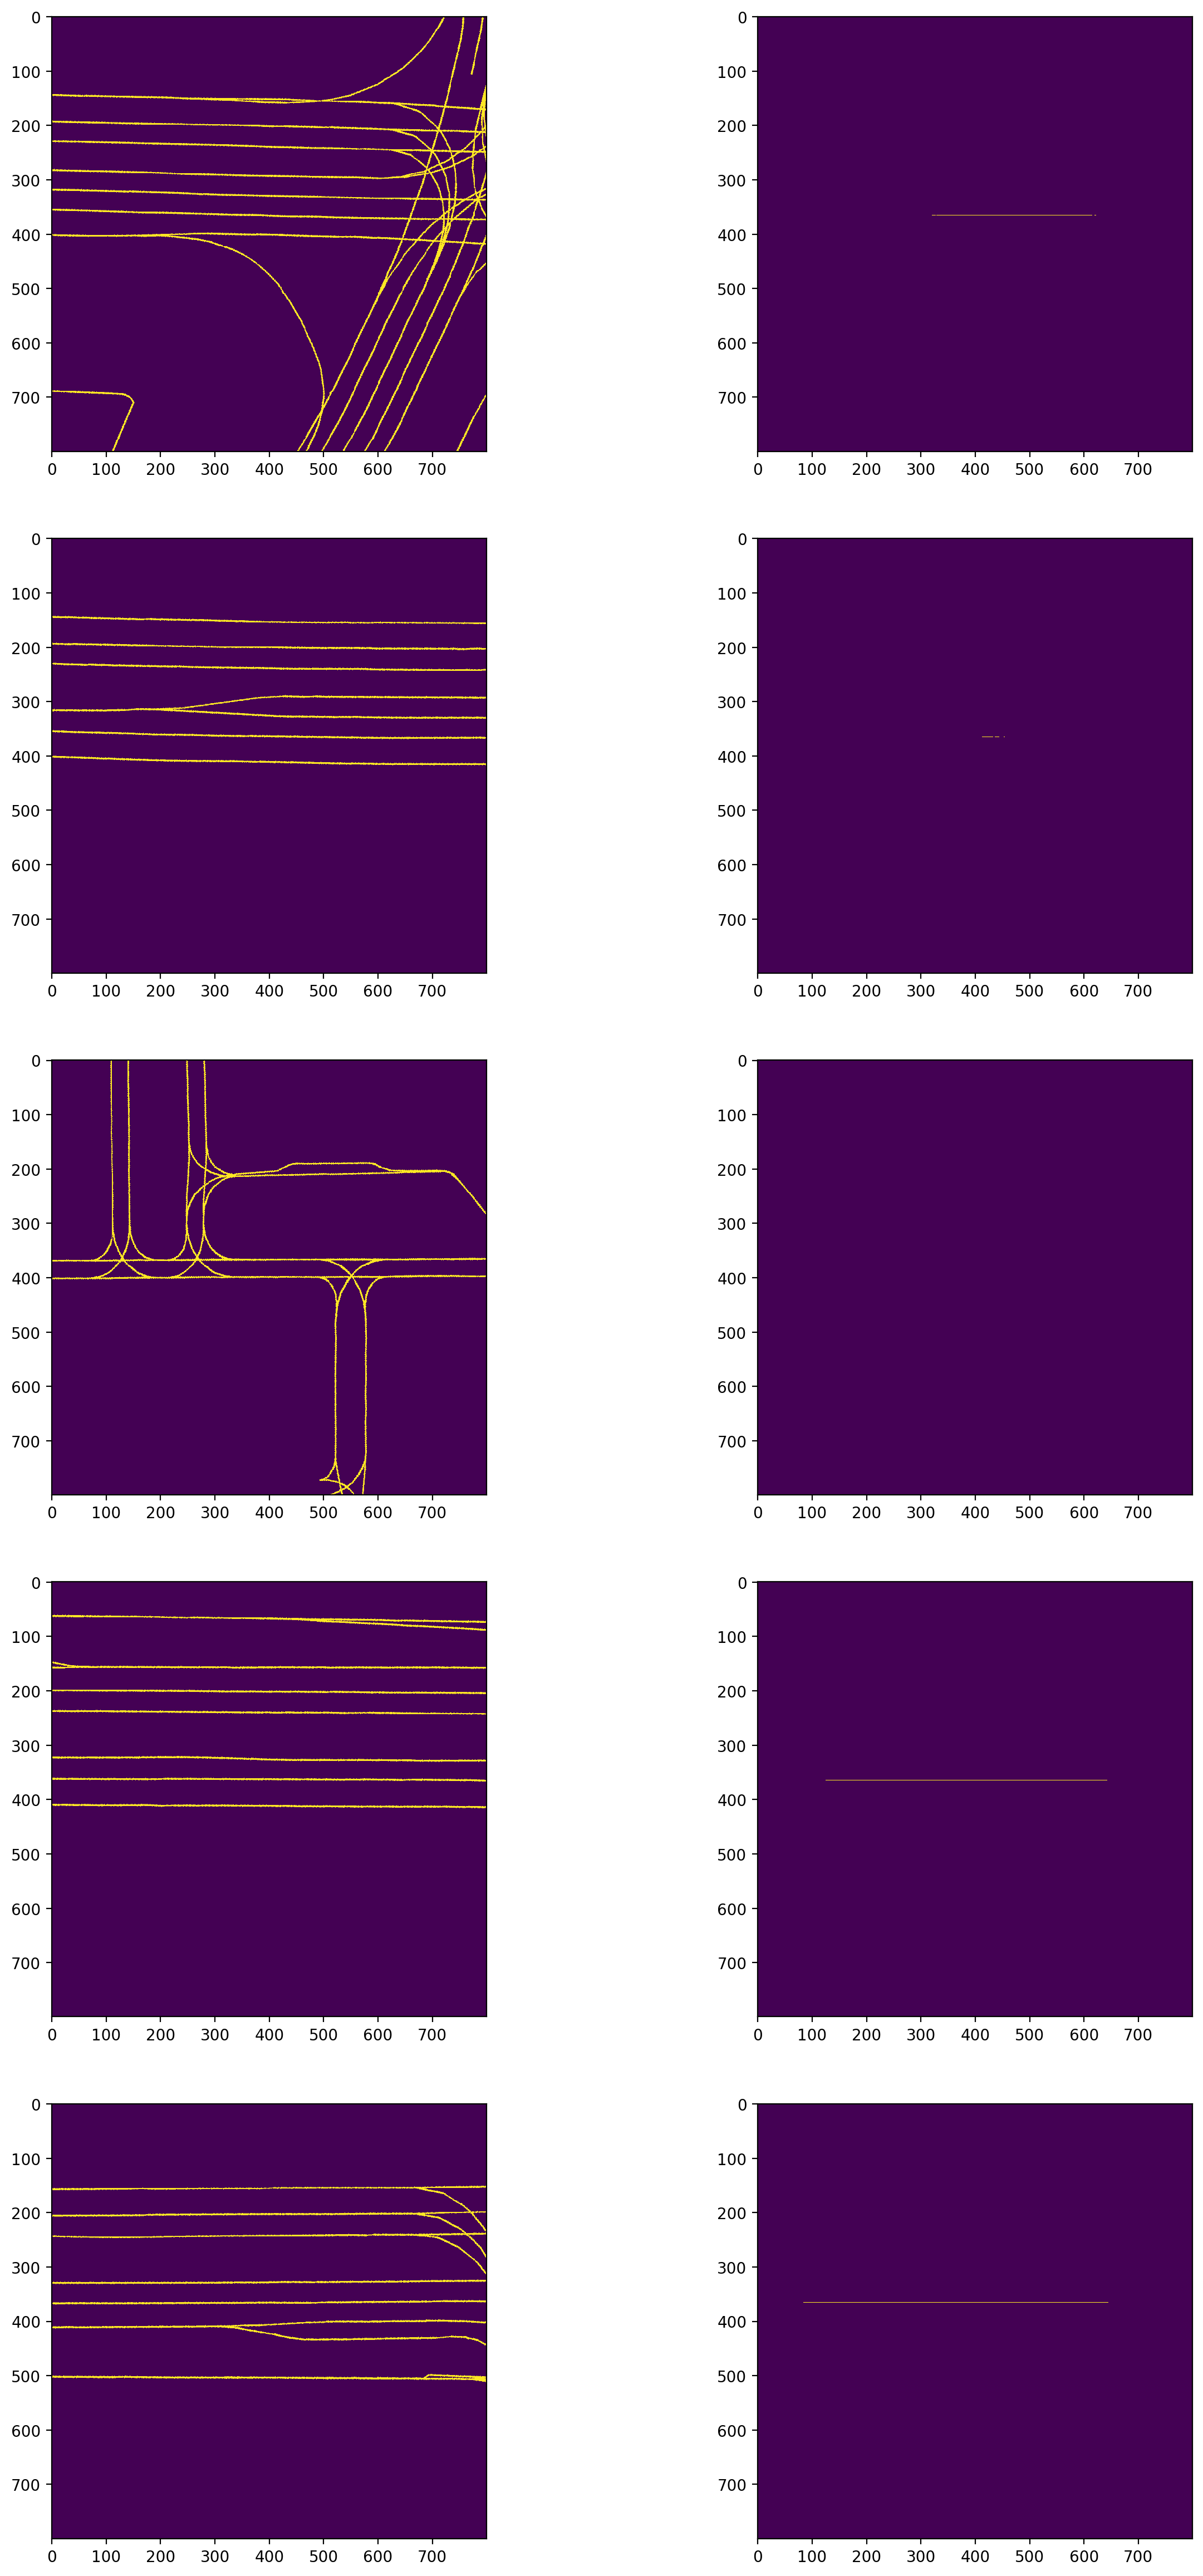

Epoch 2/20
----------
current epoch train composite loss is 314.742145
training 1 epoch takes 298.683305
current epoch val composite loss is 58.806391
valing 1 epoch takes 331.289429
Epoch 3/20
----------
current epoch train composite loss is 307.599509
training 1 epoch takes 339.329725
current epoch val composite loss is 58.609921
valing 1 epoch takes 376.223764
saving best model
Epoch 4/20
----------
current epoch train composite loss is 300.595488
training 1 epoch takes 324.714670
current epoch val composite loss is 56.119912
valing 1 epoch takes 358.026701
saving best model
Epoch 5/20
----------
current epoch train composite loss is 292.678338
training 1 epoch takes 338.911344
current epoch val composite loss is 57.050447
valing 1 epoch takes 371.603861
Epoch 6/20
----------
current epoch train composite loss is 285.317719
training 1 epoch takes 316.718637
current epoch val composite loss is 53.455157
valing 1 epoch takes 349.653371
saving best model
Epoch 7/20
----------
current e

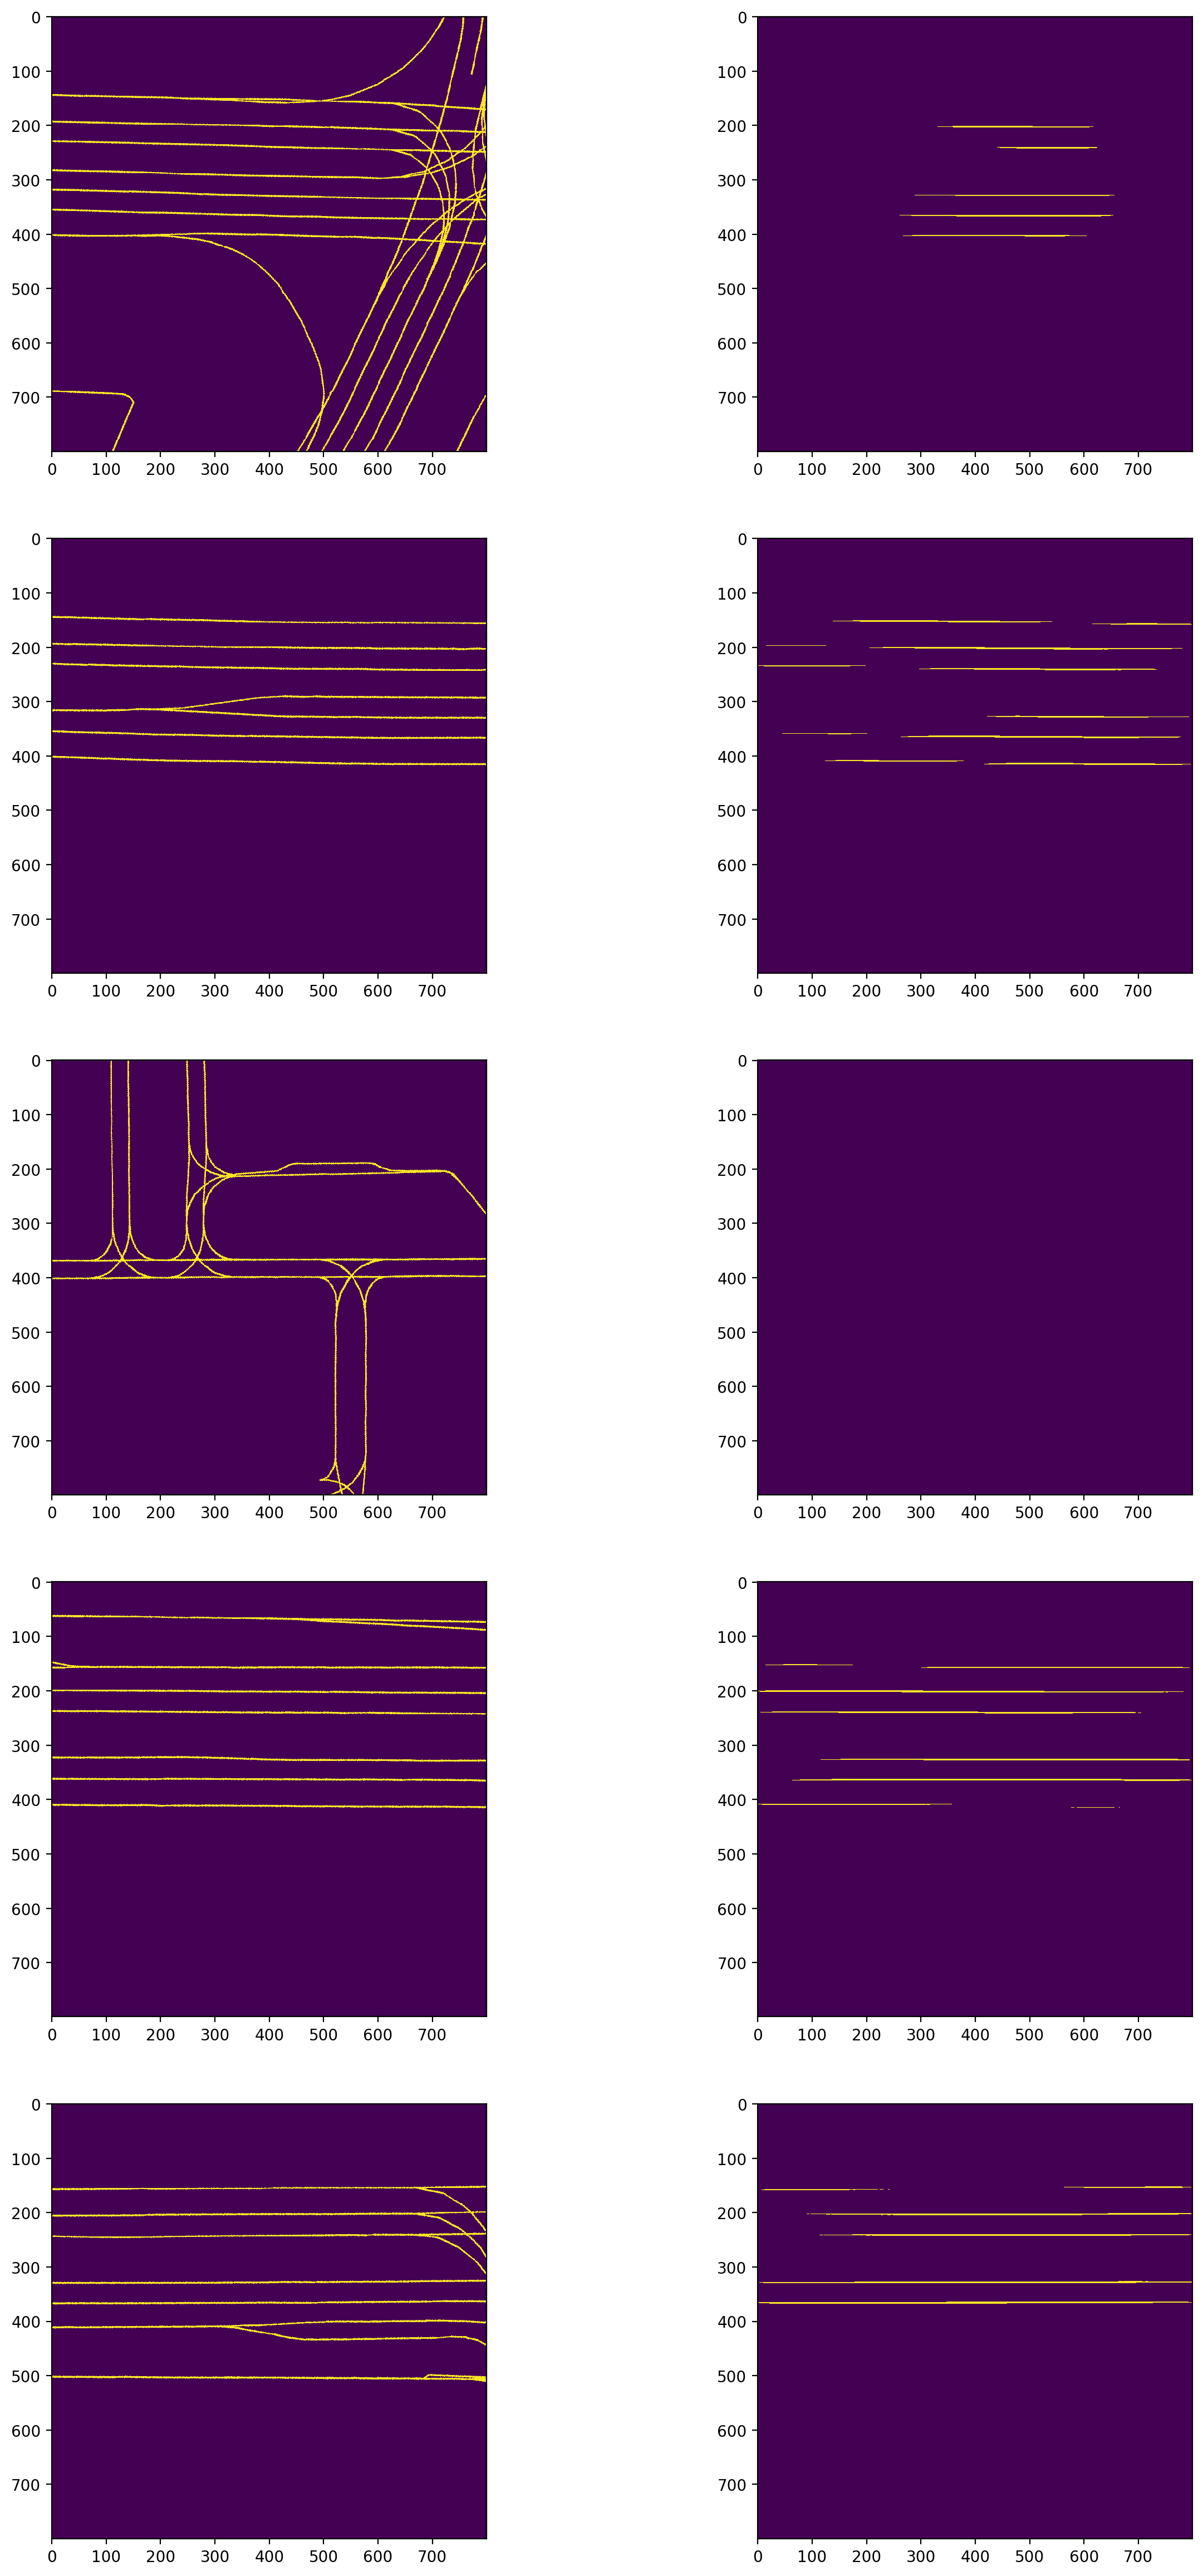

Epoch 12/20
----------
current epoch train composite loss is 249.595458
training 1 epoch takes 363.143782
current epoch val composite loss is 50.810941
valing 1 epoch takes 399.501450
saving best model
Epoch 13/20
----------
current epoch train composite loss is 246.062038
training 1 epoch takes 337.844354
current epoch val composite loss is 54.142142
valing 1 epoch takes 370.672383
Epoch 14/20
----------
current epoch train composite loss is 242.773081
training 1 epoch takes 317.126309
current epoch val composite loss is 52.648423
valing 1 epoch takes 353.684798
Epoch 15/20
----------
current epoch train composite loss is 240.642968
training 1 epoch takes 362.317554
current epoch val composite loss is 53.536669
valing 1 epoch takes 395.927119
Epoch 16/20
----------
current epoch train composite loss is 237.232314
training 1 epoch takes 341.524128
current epoch val composite loss is 52.563929
valing 1 epoch takes 377.556257
Epoch 17/20
----------
current epoch train composite loss is 2

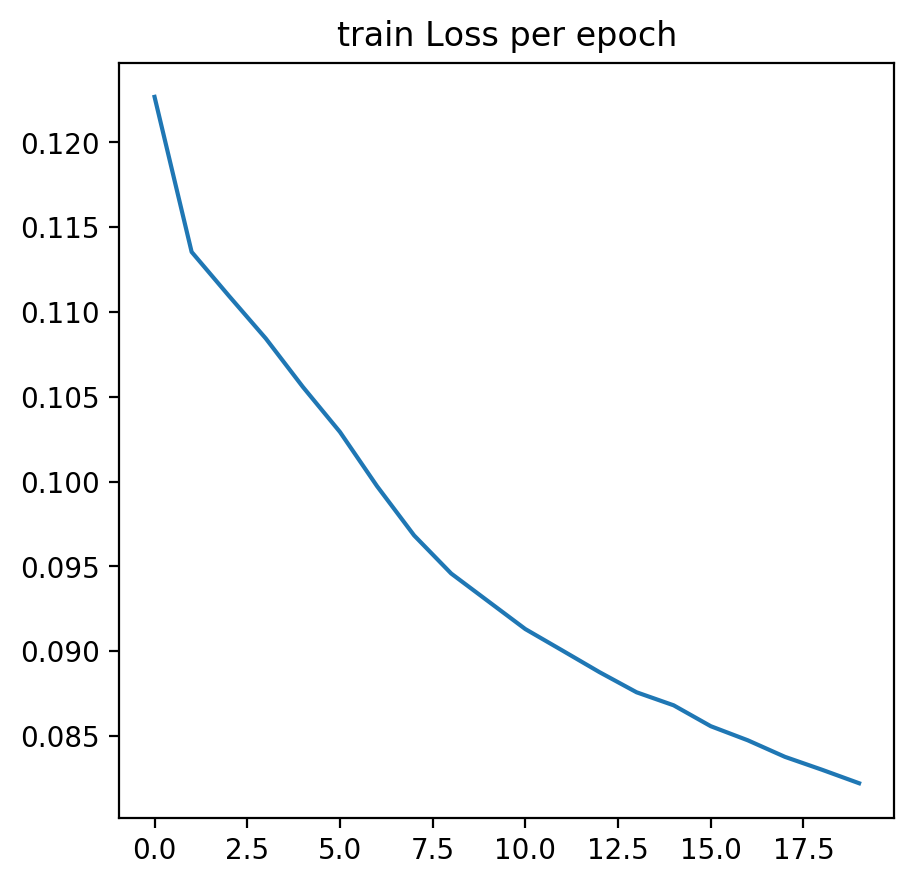

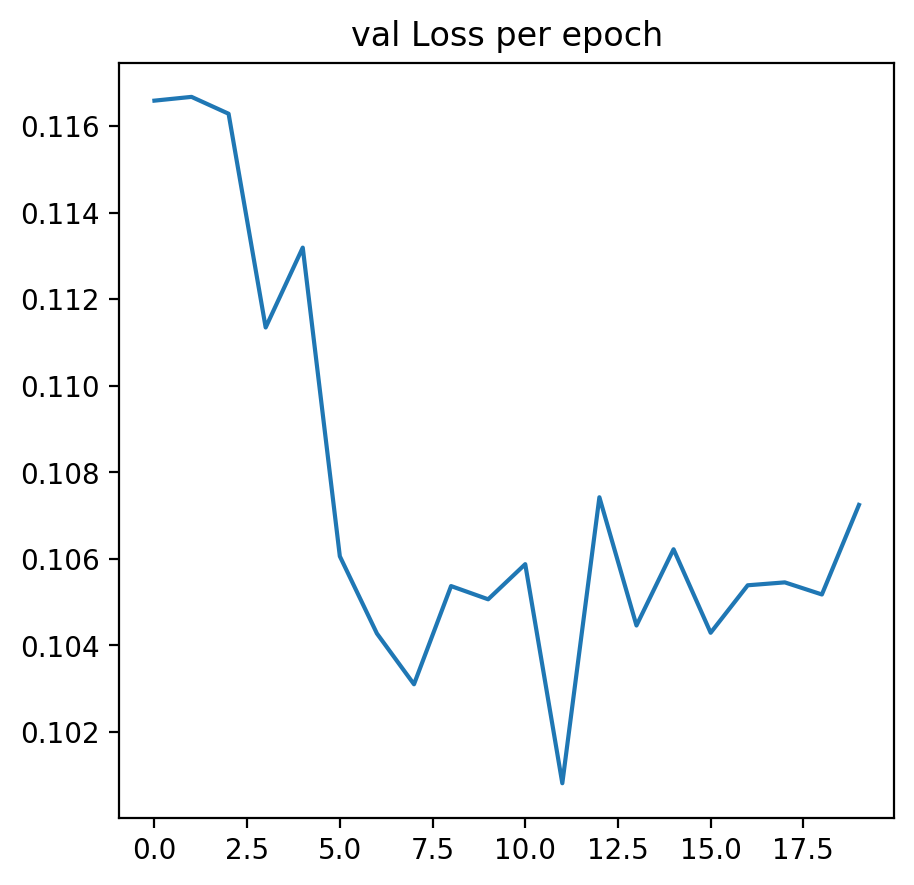

In [159]:
my_model = vae_mapping().cuda()
optimizer = torch.optim.SGD(my_model.parameters(), lr = 1e-2, momentum=0.9)
criterion = nn.BCELoss(reduction = 'mean')

optimizer2 = torch.optim.Adam(my_model.parameters(), lr=1e-4)


model, loss_dict = train_eval_model(my_model,dataloaders,criterion,loss_function = loss_function, optimizer=optimizer2, 
                num_epochs=20, checkpoint=None, to_save = '/scratch/ht1162/DLResult/vae_pretrain_lane3.pth', 
                                    print_every=10, eval_every = 1, to_eval = True )

Epoch 1/10
----------
current epoch train composite loss is 245.665620
training 1 epoch takes 360.700711
current epoch val composite loss is 50.899426
valing 1 epoch takes 395.684104
printing test image


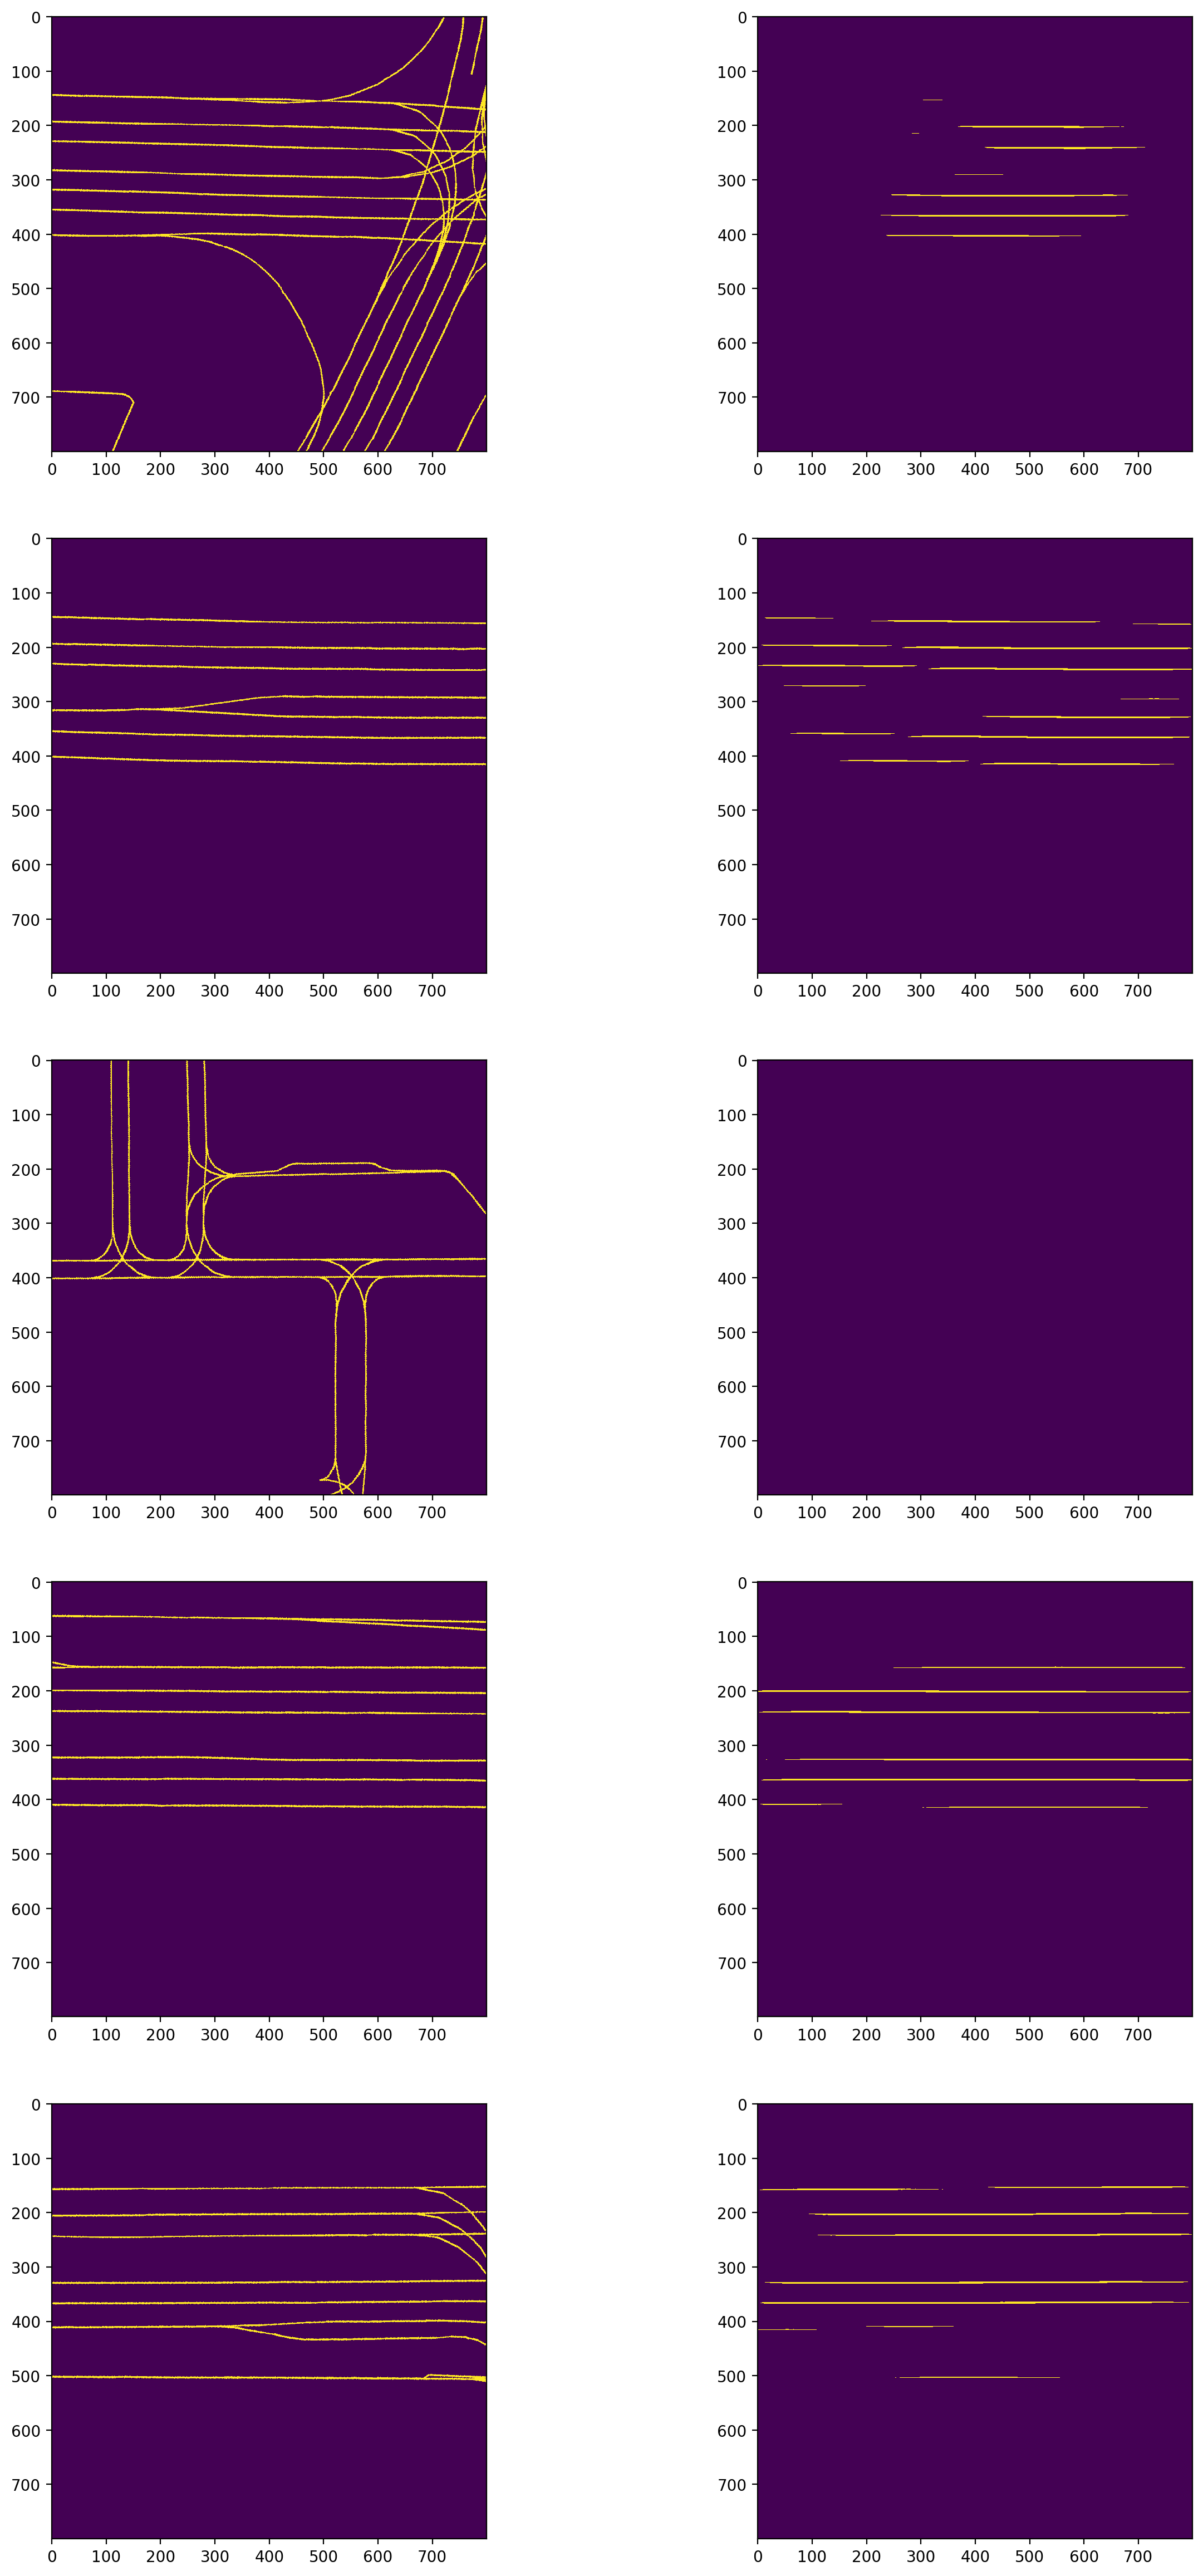

Epoch 2/10
----------
current epoch train composite loss is 242.994053
training 1 epoch takes 330.245895
current epoch val composite loss is 51.324821
valing 1 epoch takes 363.430346
Epoch 3/10
----------
current epoch train composite loss is 240.573161
training 1 epoch takes 360.011911
current epoch val composite loss is 53.193680
valing 1 epoch takes 392.584291
Epoch 4/10
----------
current epoch train composite loss is 237.696896
training 1 epoch takes 332.655896
current epoch val composite loss is 53.420127
valing 1 epoch takes 368.791588
Epoch 5/10
----------
current epoch train composite loss is 235.914505
training 1 epoch takes 359.594548
current epoch val composite loss is 54.011955
valing 1 epoch takes 392.077504
Epoch 6/10
----------
current epoch train composite loss is 232.229552
training 1 epoch takes 336.392815
current epoch val composite loss is 53.450872
valing 1 epoch takes 373.846292
Epoch 7/10
----------
current epoch train composite loss is 230.541077
training 1 epo

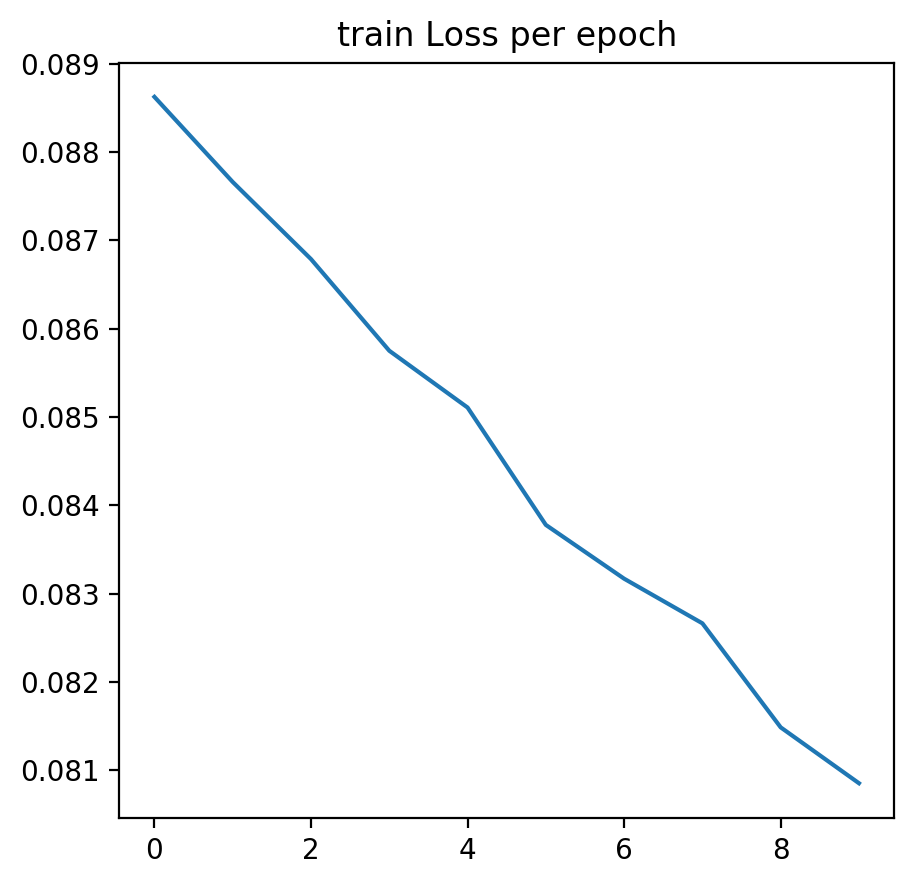

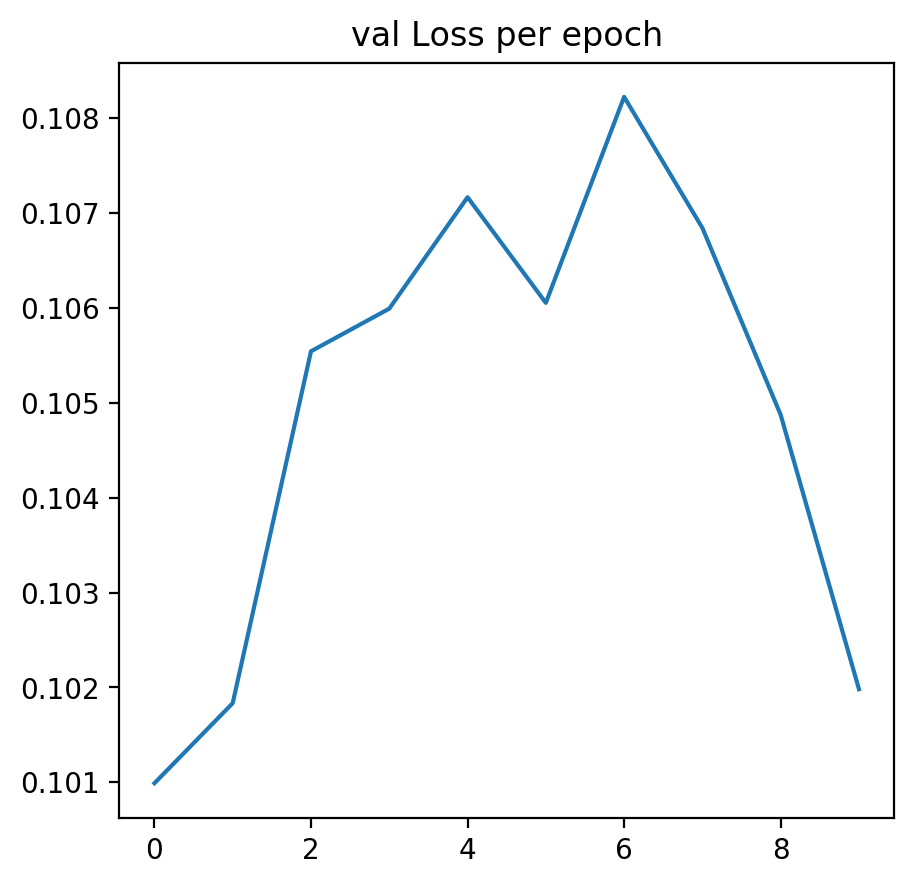

In [163]:
my_model = vae_mapping().cuda()
optimizer = torch.optim.SGD(my_model.parameters(), lr = 1e-2, momentum=0.9)
criterion = nn.BCELoss(reduction = 'mean')

optimizer2 = torch.optim.Adam(my_model.parameters(), lr=1e-4)


model, loss_dict = train_eval_model(my_model,dataloaders,criterion,loss_function = loss_function, optimizer=optimizer2, 
                num_epochs=10, checkpoint='/scratch/ht1162/DLResult/vae_pretrain_lane3.pth', to_save = '/scratch/ht1162/DLResult/vae_pretrain_lane3.pth', 
                                    print_every=10, eval_every = 1, to_eval = True )

In [ ]:
my_model = vae_mapping().cuda()
optimizer = torch.optim.SGD(my_model.parameters(), lr = 1e-2, momentum=0.9)
criterion = nn.BCELoss(reduction = 'mean')

optimizer2 = torch.optim.Adam(my_model.parameters(), lr=1e-4)


model, loss_dict = train_eval_model(my_model,dataloaders,criterion,loss_function = loss_function, optimizer=optimizer2, 
                num_epochs=10, checkpoint='/scratch/ht1162/DLResult/vae_pretrain_lane3.pth', to_save = '/scratch/ht1162/DLResult/vae_pretrain_lane3.pth', 
                                    print_every=10, eval_every = 1, to_eval = True )

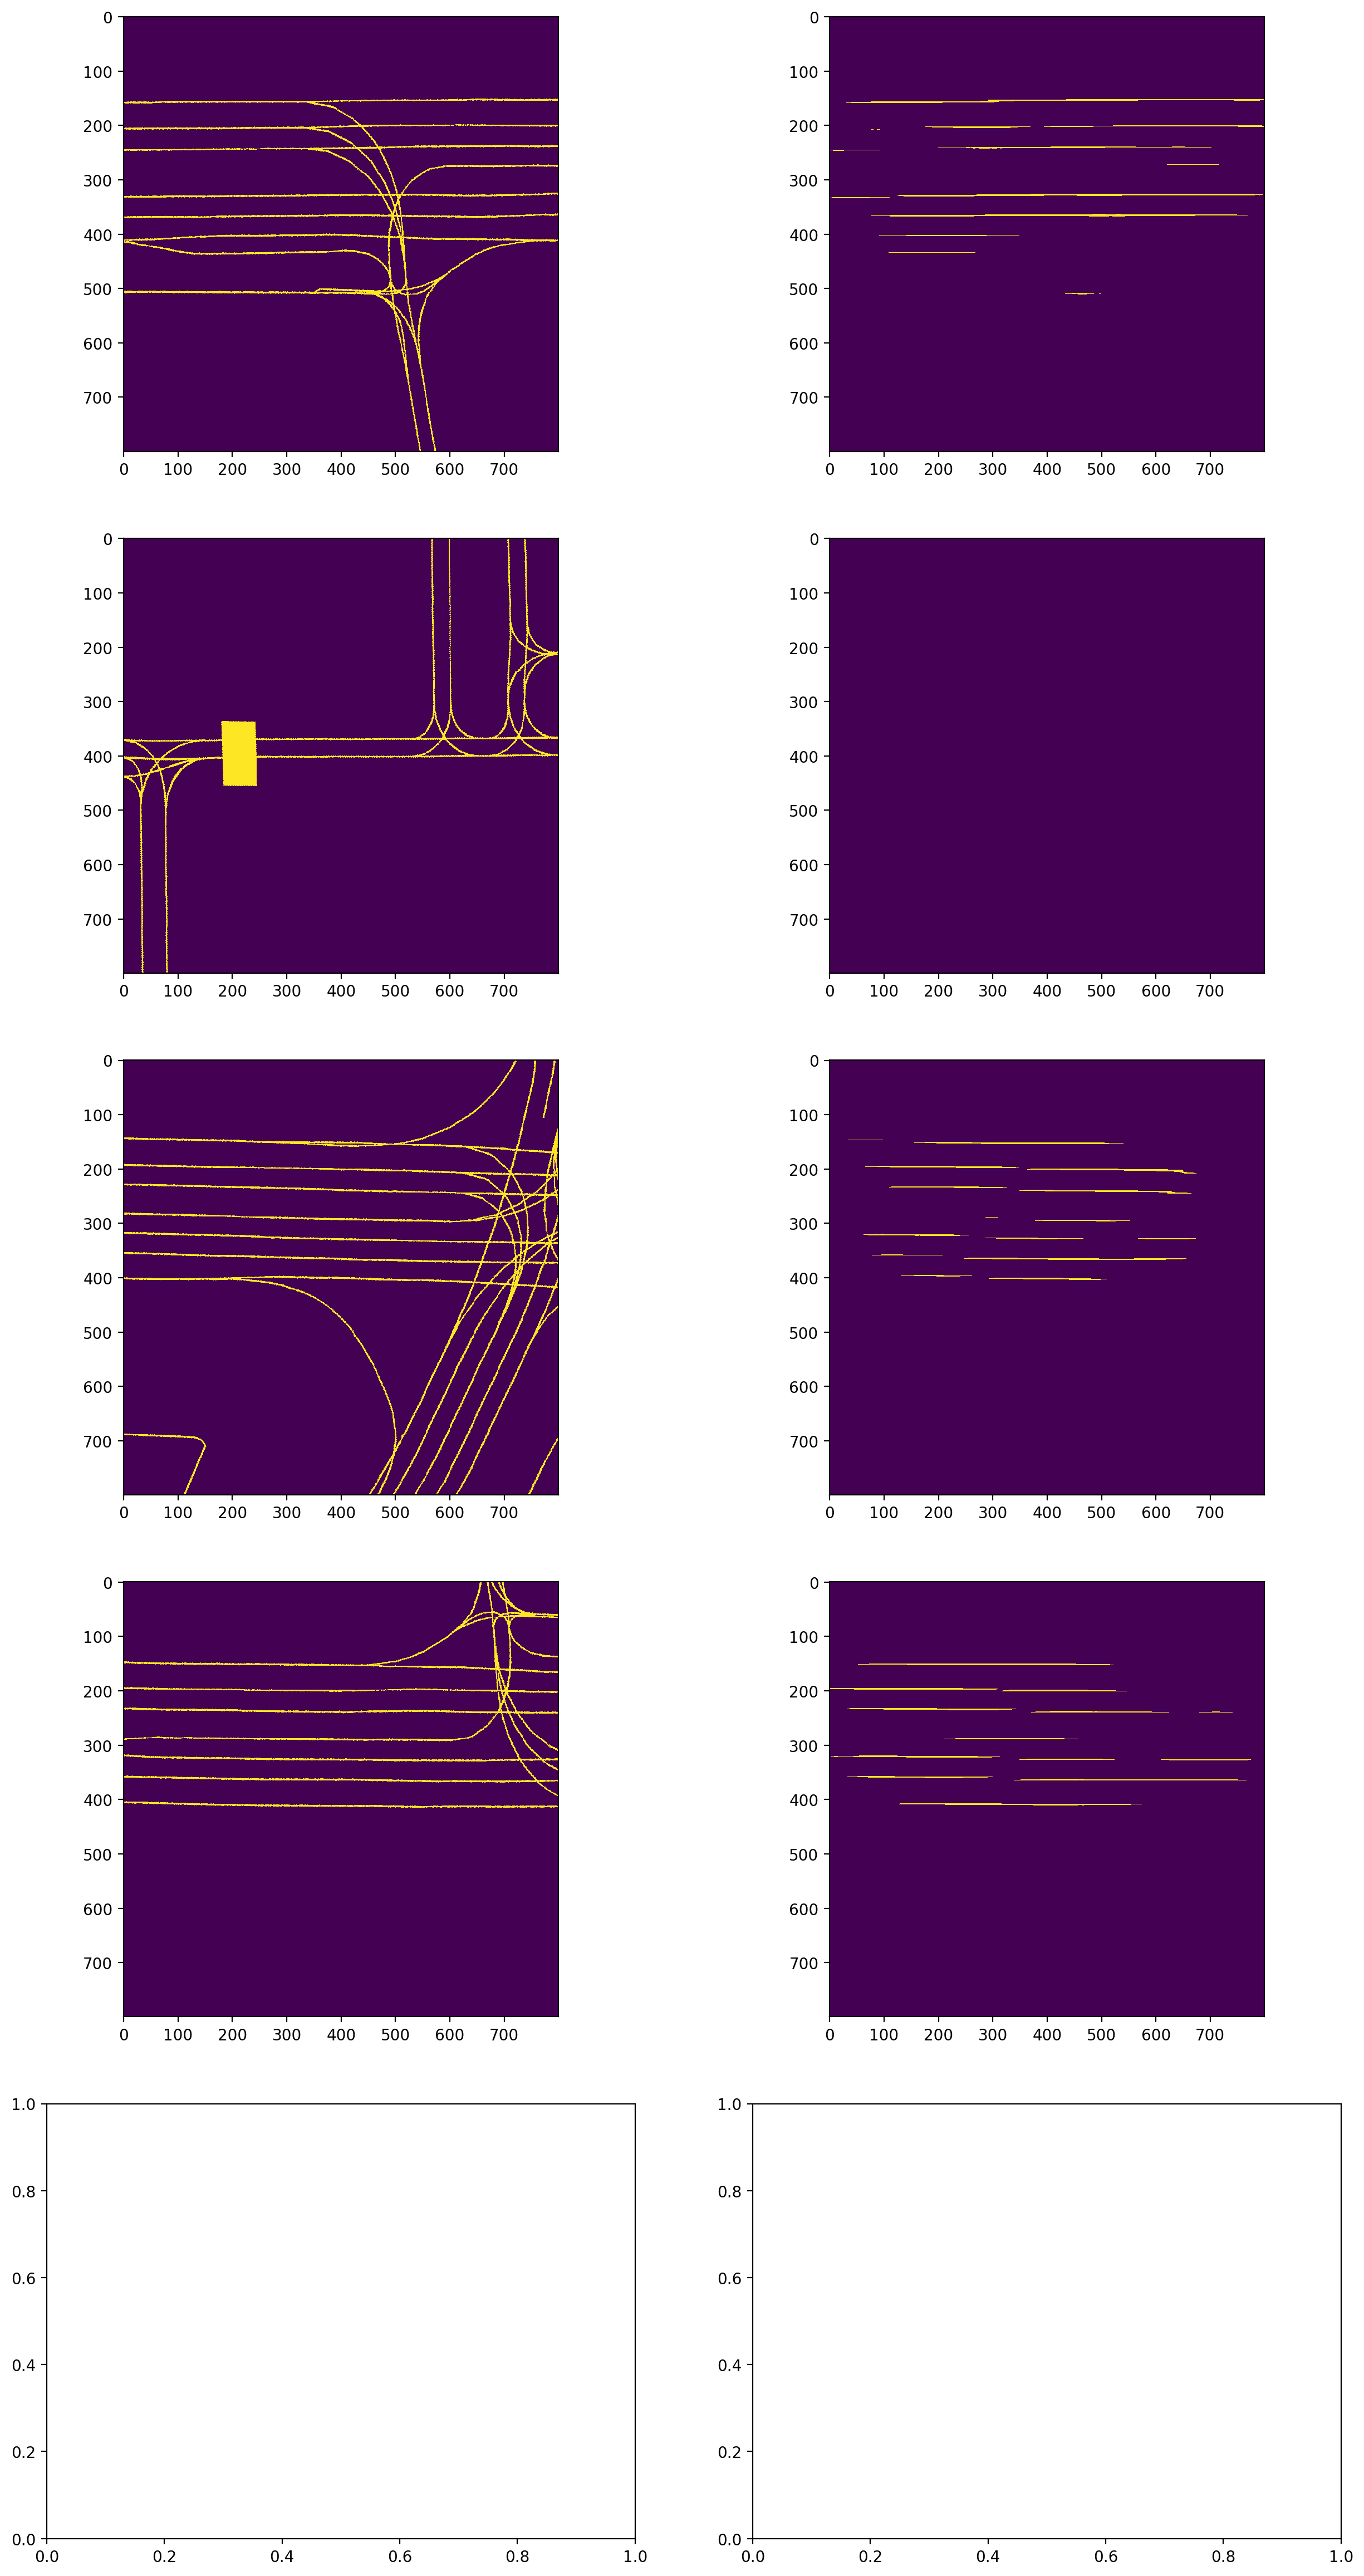

In [162]:
fig, ax = plt.subplots(5, 2, figsize=(15,30))
test_idx = [32,419,221,313]
for fig_i, i in enumerate(test_idx):
    inputs = val_set[i][-1]['lane_image'].type(torch.FloatTensor).to(device).unsqueeze(0).unsqueeze(0)
    with torch.no_grad():
        outputs = model(inputs, is_training=False)[0].cpu().squeeze().detach()

    ax[fig_i, 0].imshow(val_set[i][-1]['lane_image'].cpu())

    ax[fig_i, 1].imshow((outputs>0.5).numpy())
plt.show()

Epoch 1/20
----------
current epoch train composite loss is 1693.189917
training 1 epoch takes 192.944117
current epoch val composite loss is 367.378688
valing 1 epoch takes 216.244307
saving best model
printing test image


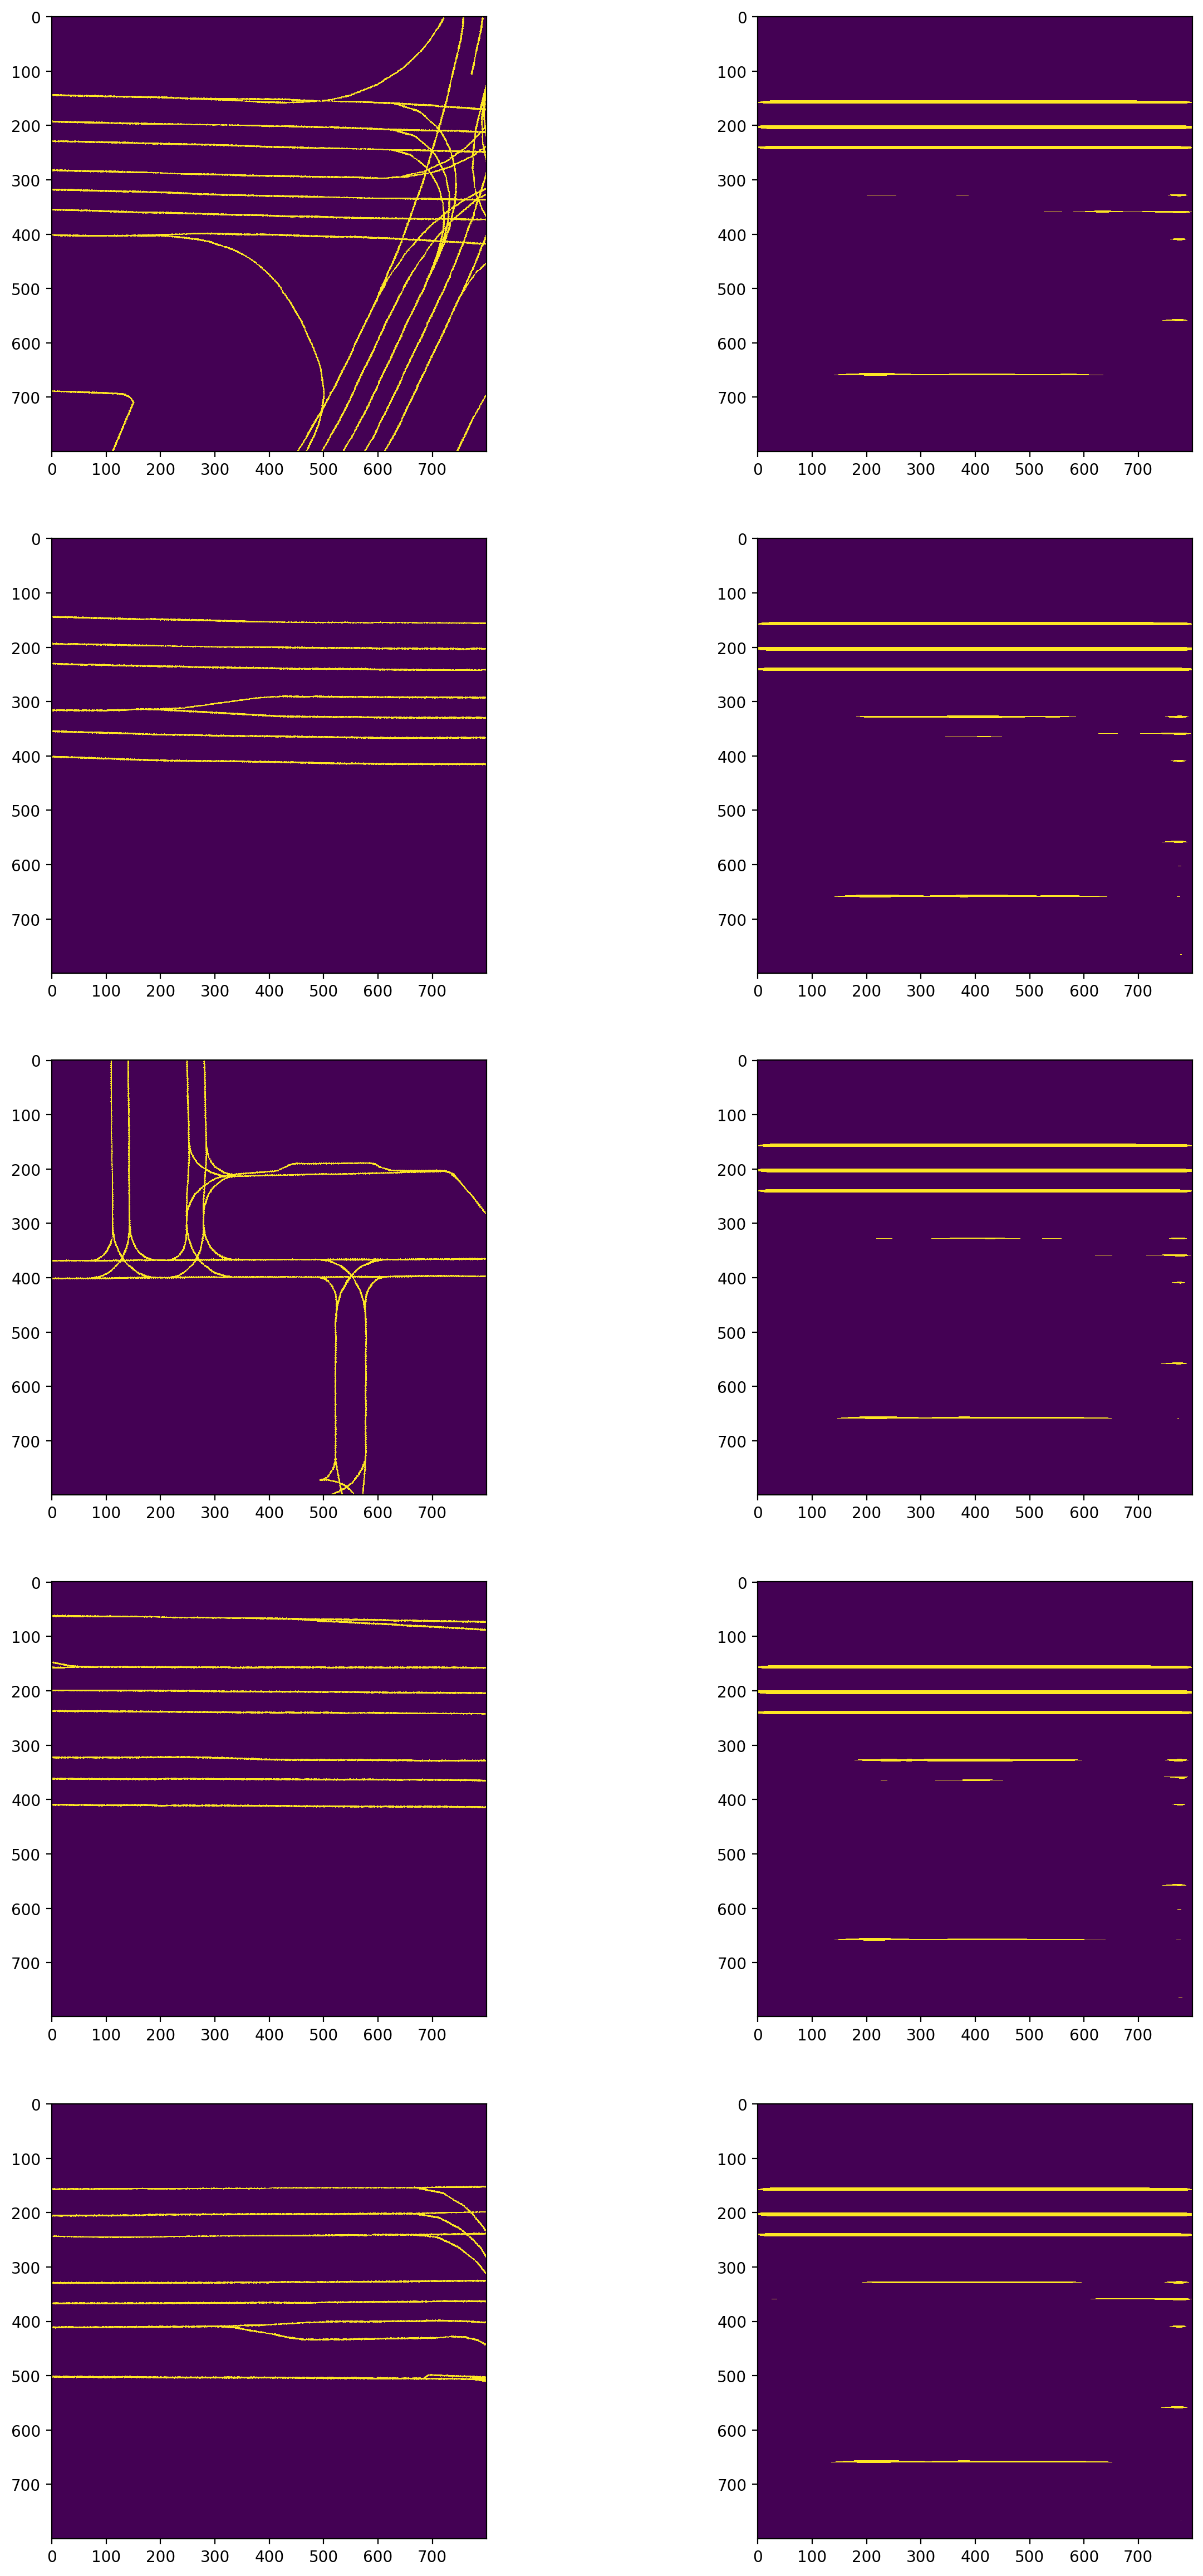

Epoch 2/20
----------
current epoch train composite loss is 1656.722909
training 1 epoch takes 231.048643
current epoch val composite loss is 369.475286
valing 1 epoch takes 254.665543
Epoch 3/20
----------
current epoch train composite loss is 1655.796558
training 1 epoch takes 198.947314
current epoch val composite loss is 370.129987
valing 1 epoch takes 218.767402
Epoch 4/20
----------
current epoch train composite loss is 1655.397787
training 1 epoch takes 182.872574
current epoch val composite loss is 352.147281
valing 1 epoch takes 211.135189
saving best model
Epoch 5/20
----------
current epoch train composite loss is 1655.530721
training 1 epoch takes 218.554347
current epoch val composite loss is 360.716185
valing 1 epoch takes 236.988554
Epoch 6/20
----------
current epoch train composite loss is 1654.824909
training 1 epoch takes 188.686456
current epoch val composite loss is 365.511463
valing 1 epoch takes 212.003918
Epoch 7/20
----------
current epoch train composite loss 

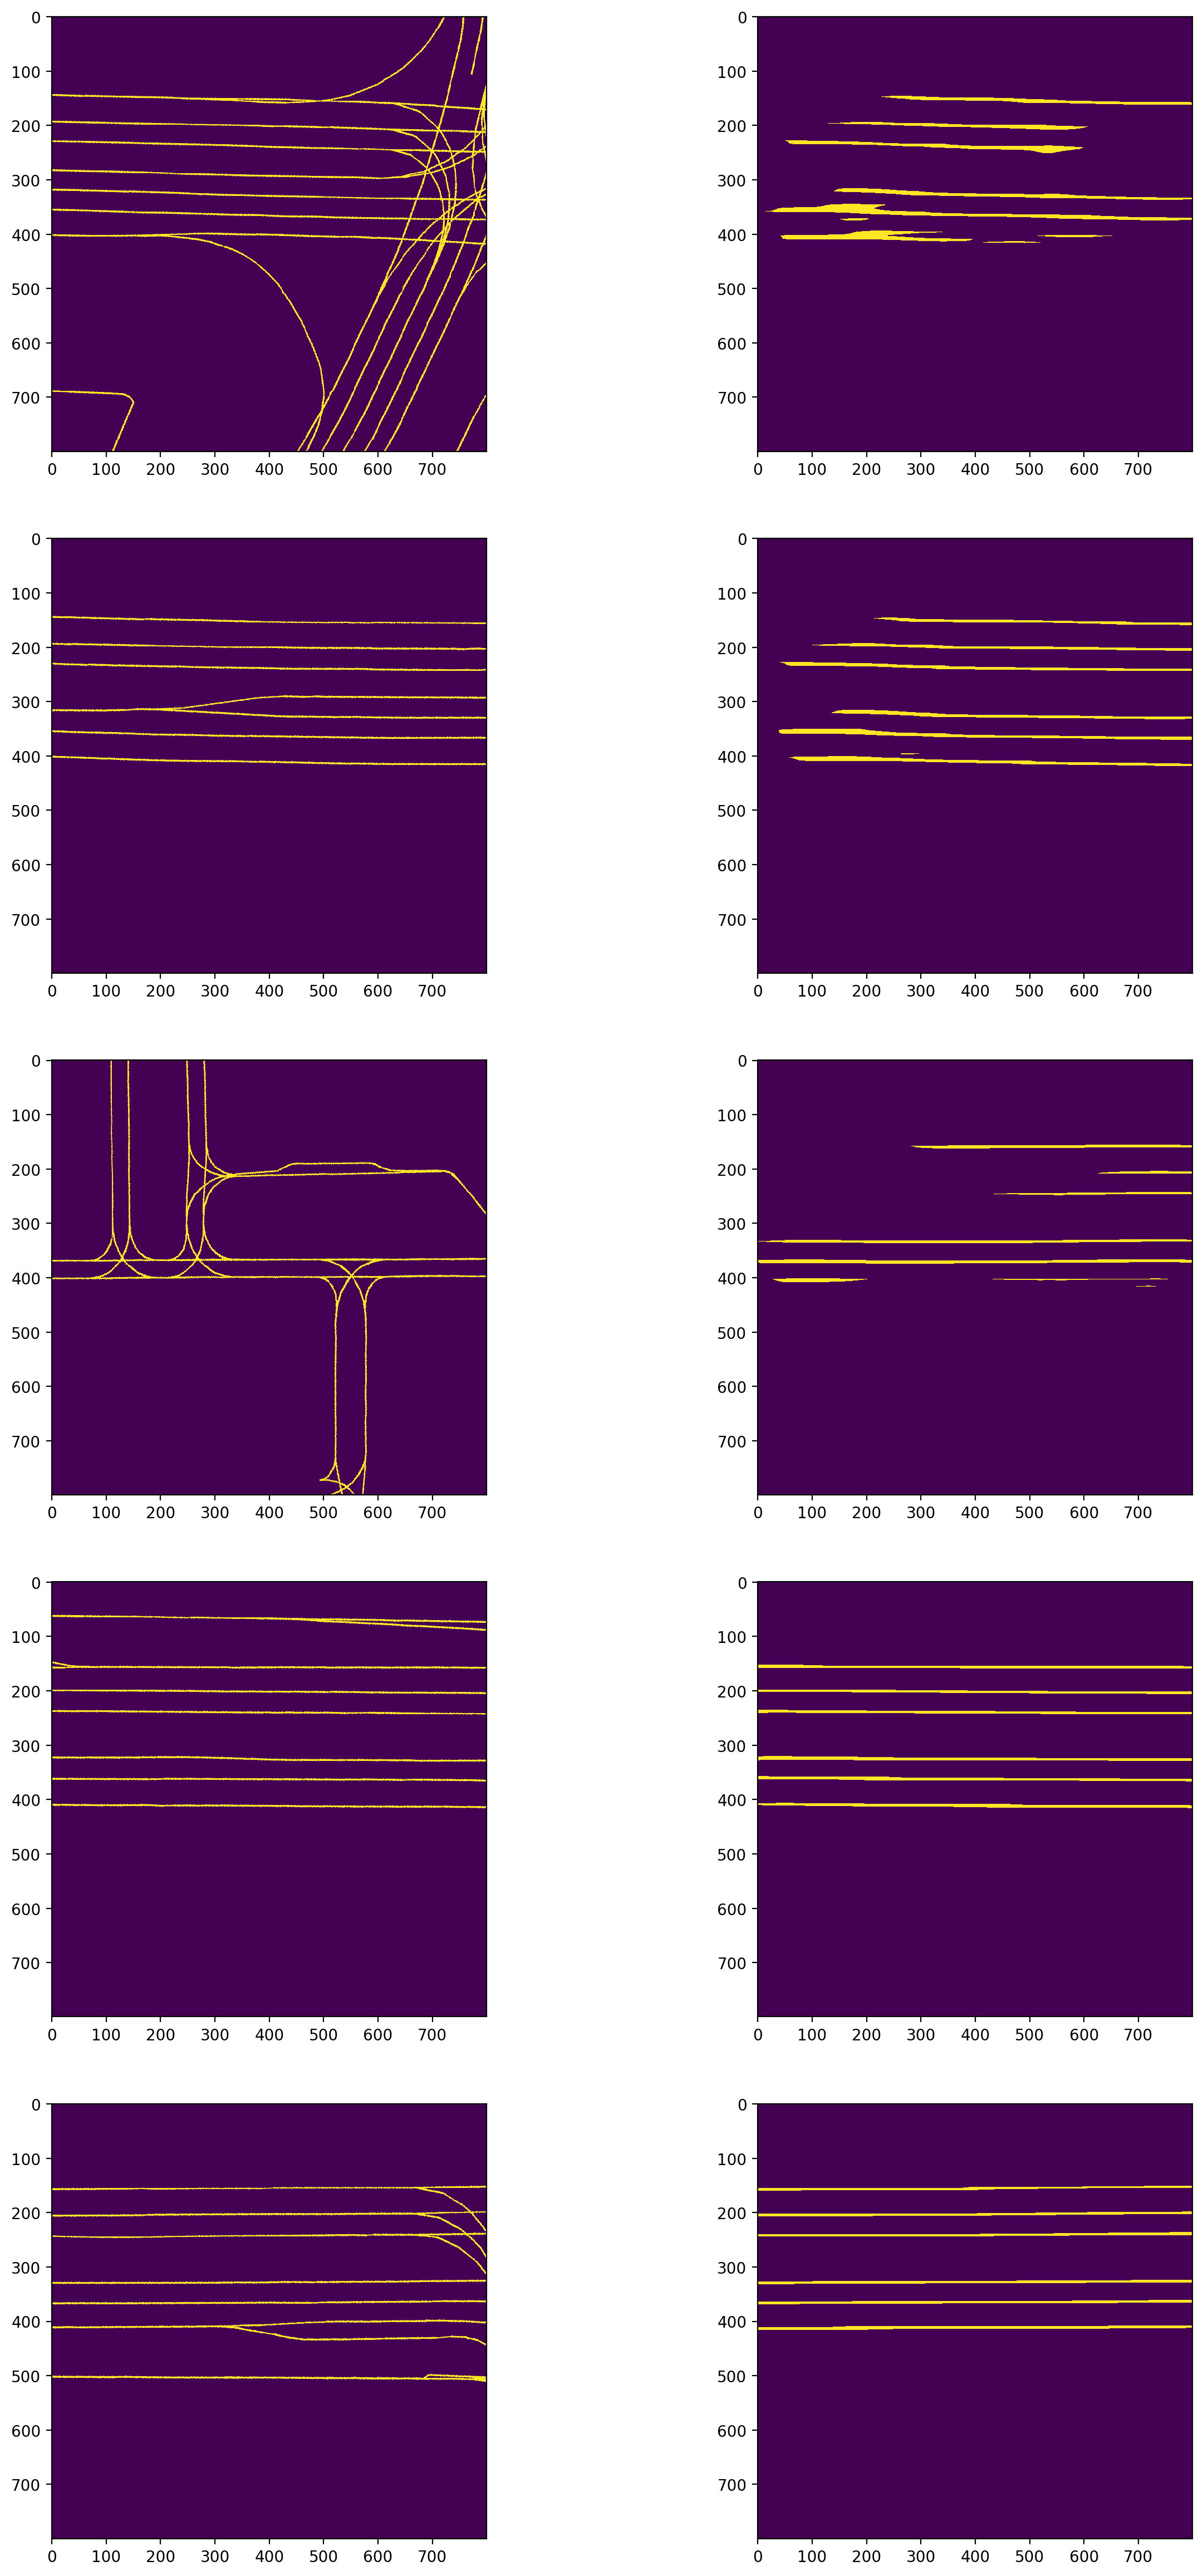

Epoch 12/20
----------
current epoch train composite loss is 1313.193251
training 1 epoch takes 192.934726
current epoch val composite loss is 257.779515
valing 1 epoch takes 212.562346
saving best model
Epoch 13/20
----------
current epoch train composite loss is 1287.503814
training 1 epoch takes 193.240047
current epoch val composite loss is 252.699374
valing 1 epoch takes 211.855367
saving best model
Epoch 14/20
----------
current epoch train composite loss is 1267.840339
training 1 epoch takes 180.592386
current epoch val composite loss is 252.407160
valing 1 epoch takes 201.921063
saving best model
Epoch 15/20
----------
current epoch train composite loss is 1243.160813
training 1 epoch takes 199.847305
current epoch val composite loss is 251.022499
valing 1 epoch takes 220.075664
saving best model
Epoch 16/20
----------
current epoch train composite loss is 1222.112276
training 1 epoch takes 233.423190
current epoch val composite loss is 270.159064
valing 1 epoch takes 251.94611

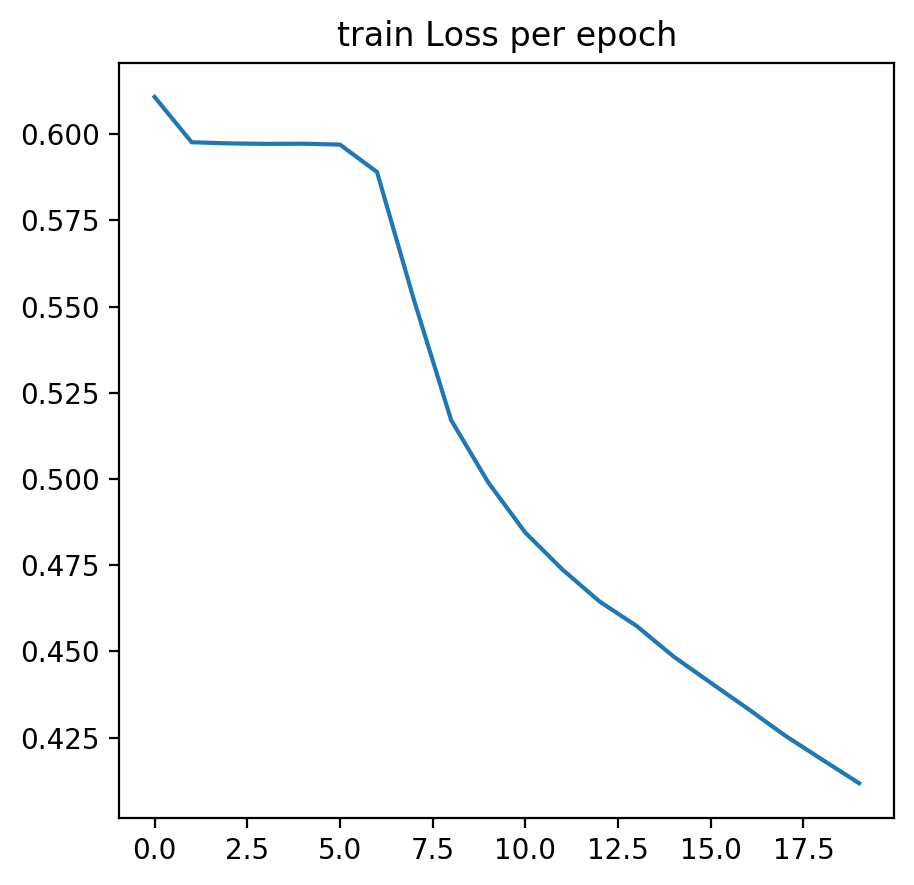

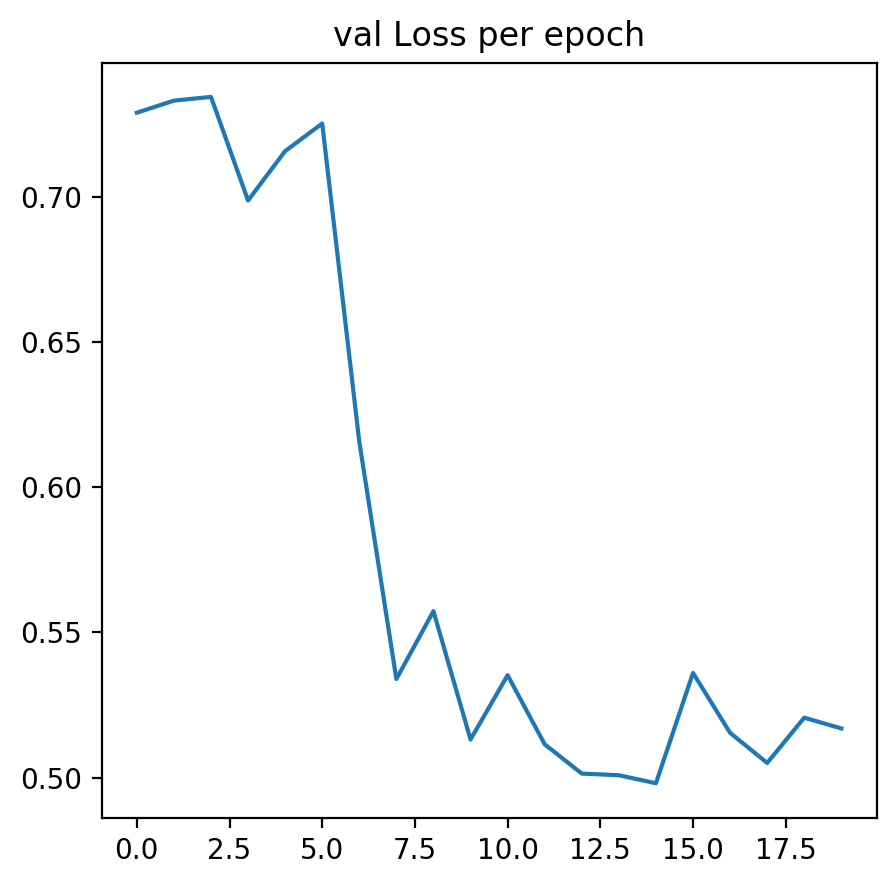

In [55]:
my_model = vae_mapping().cuda()
optimizer = torch.optim.SGD(my_model.parameters(), lr = 1e-2, momentum=0.9)
#optimizer2 = torch.optim.Adam(my_model.parameters(), lr=1e-4)
model, loss_dict = train_eval_model(my_model,dataloaders,loss_function, optimizer, 
                num_epochs=20, checkpoint=None, to_save = '/scratch/ht1162/DLResult/vae_pretrain_lane.pth', 
                                    print_every=10, eval_every = 1, to_eval = True )

Epoch 1/30
----------
current epoch train composite loss is 1222.200512
training 1 epoch takes 188.488391
current epoch val composite loss is 257.301147
valing 1 epoch takes 209.482845
printing test image


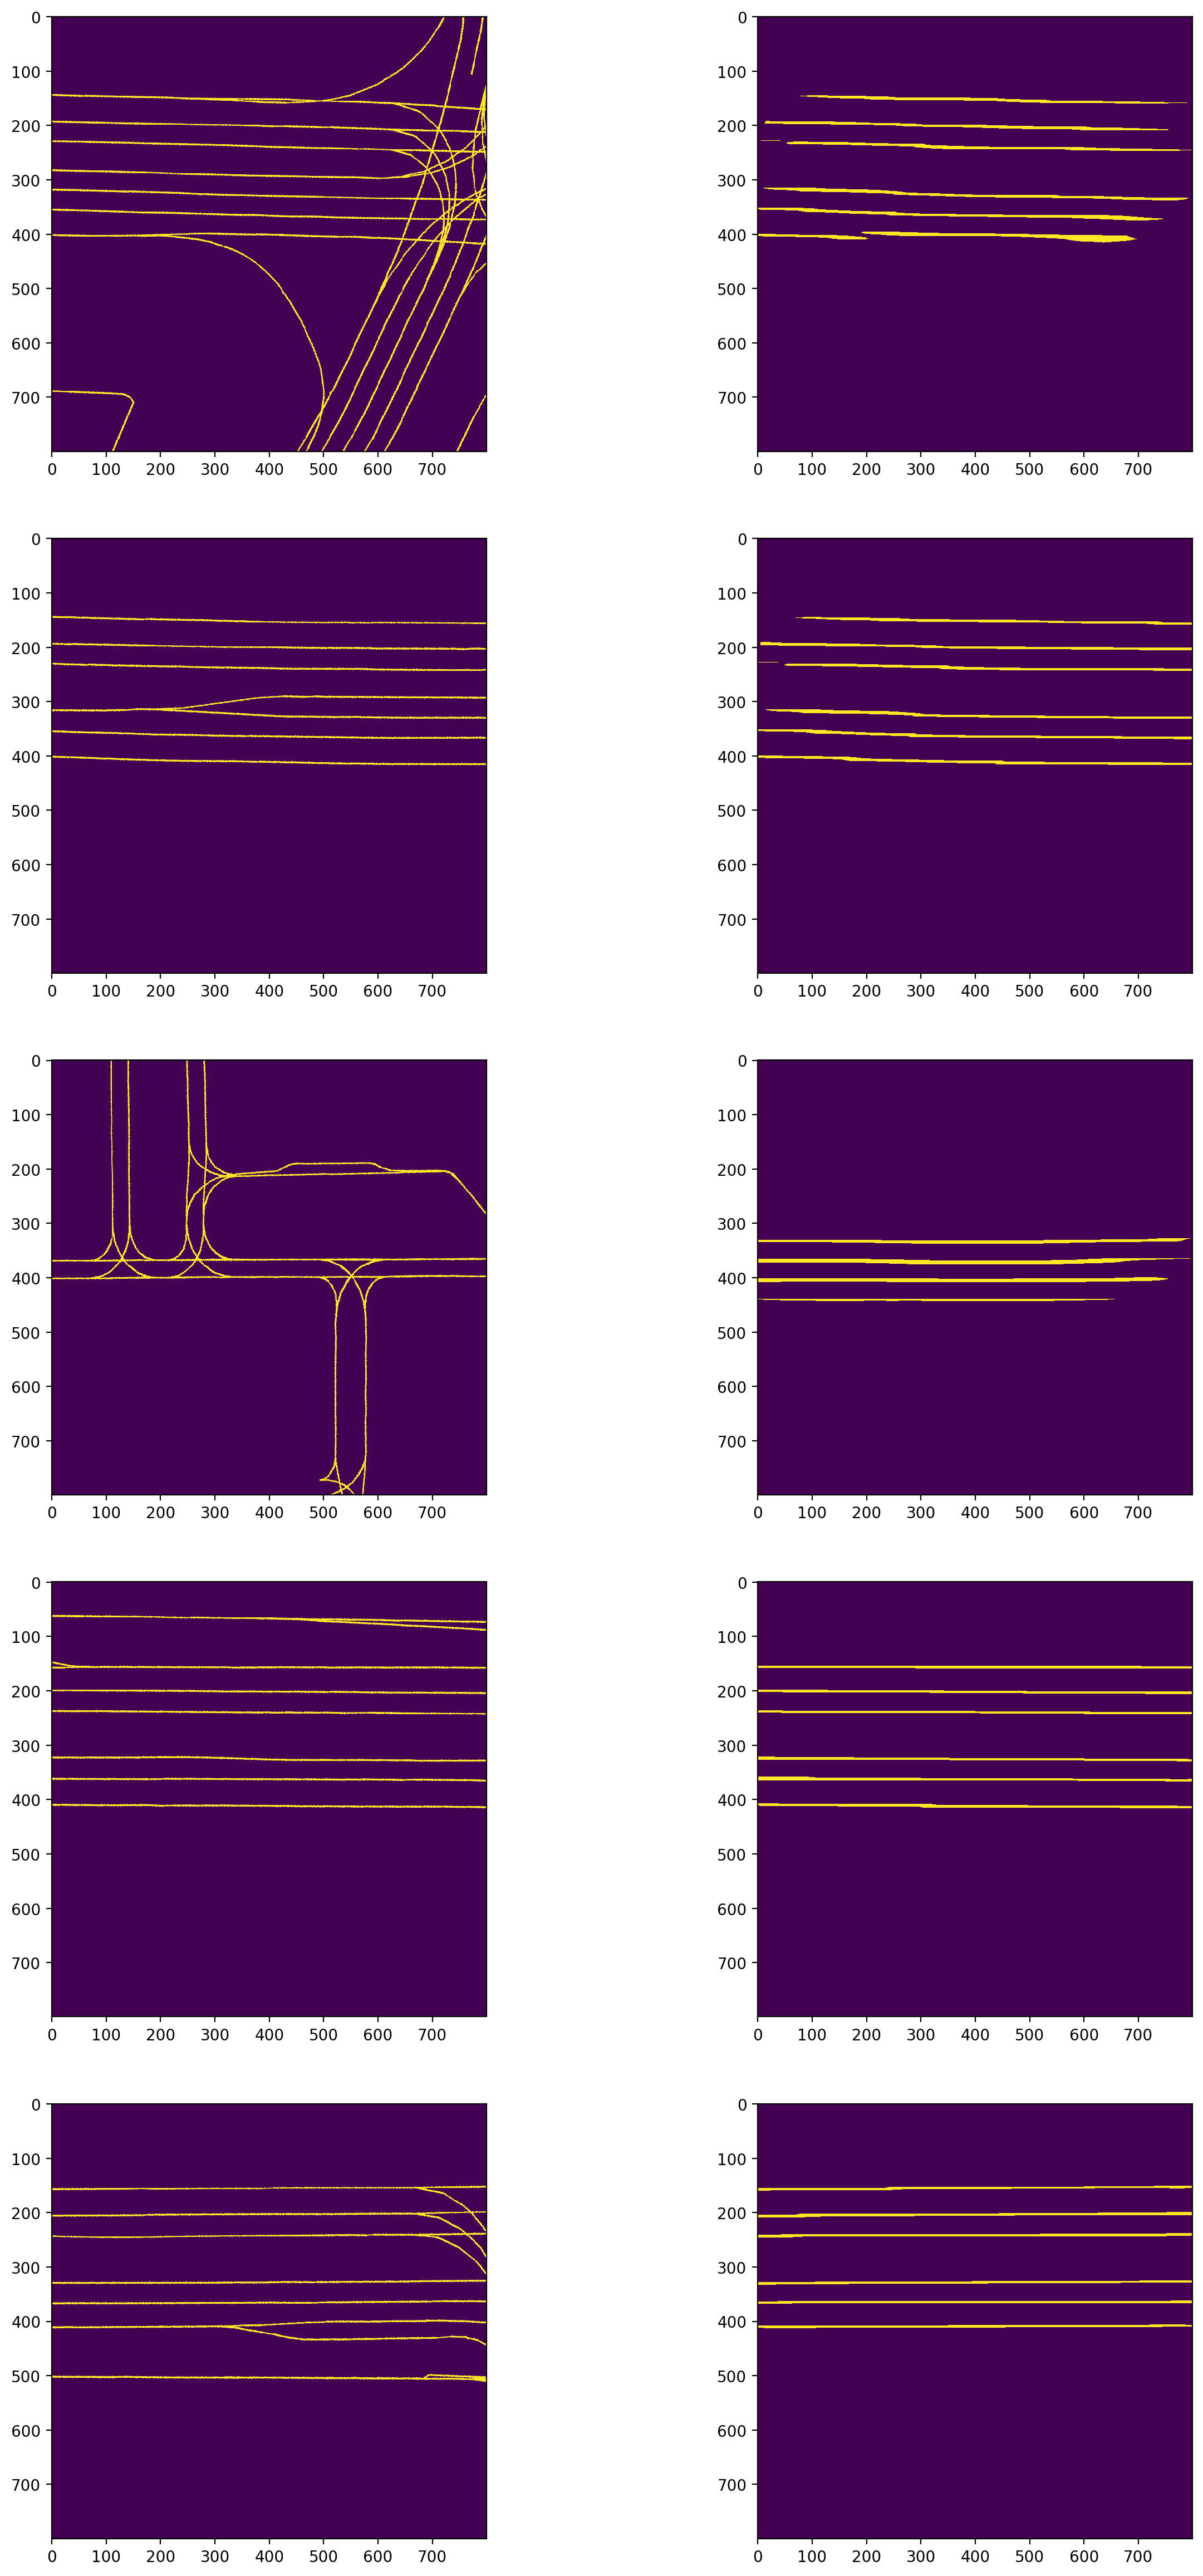

Epoch 2/30
----------
current epoch train composite loss is 1200.683113
training 1 epoch takes 185.590151
current epoch val composite loss is 251.317441
valing 1 epoch takes 204.787791
Epoch 3/30
----------
current epoch train composite loss is 1188.592088
training 1 epoch takes 190.148892
current epoch val composite loss is 261.815456
valing 1 epoch takes 210.609674
Epoch 4/30
----------
current epoch train composite loss is 1160.989044
training 1 epoch takes 191.323853
current epoch val composite loss is 258.898314
valing 1 epoch takes 210.357911
Epoch 5/30
----------
current epoch train composite loss is 1143.734822
training 1 epoch takes 190.159921
current epoch val composite loss is 259.521179
valing 1 epoch takes 208.510438
Epoch 6/30
----------
current epoch train composite loss is 1124.379944
training 1 epoch takes 179.970798
current epoch val composite loss is 247.089807
valing 1 epoch takes 199.087864
saving best model
Epoch 7/30
----------
current epoch train composite loss 

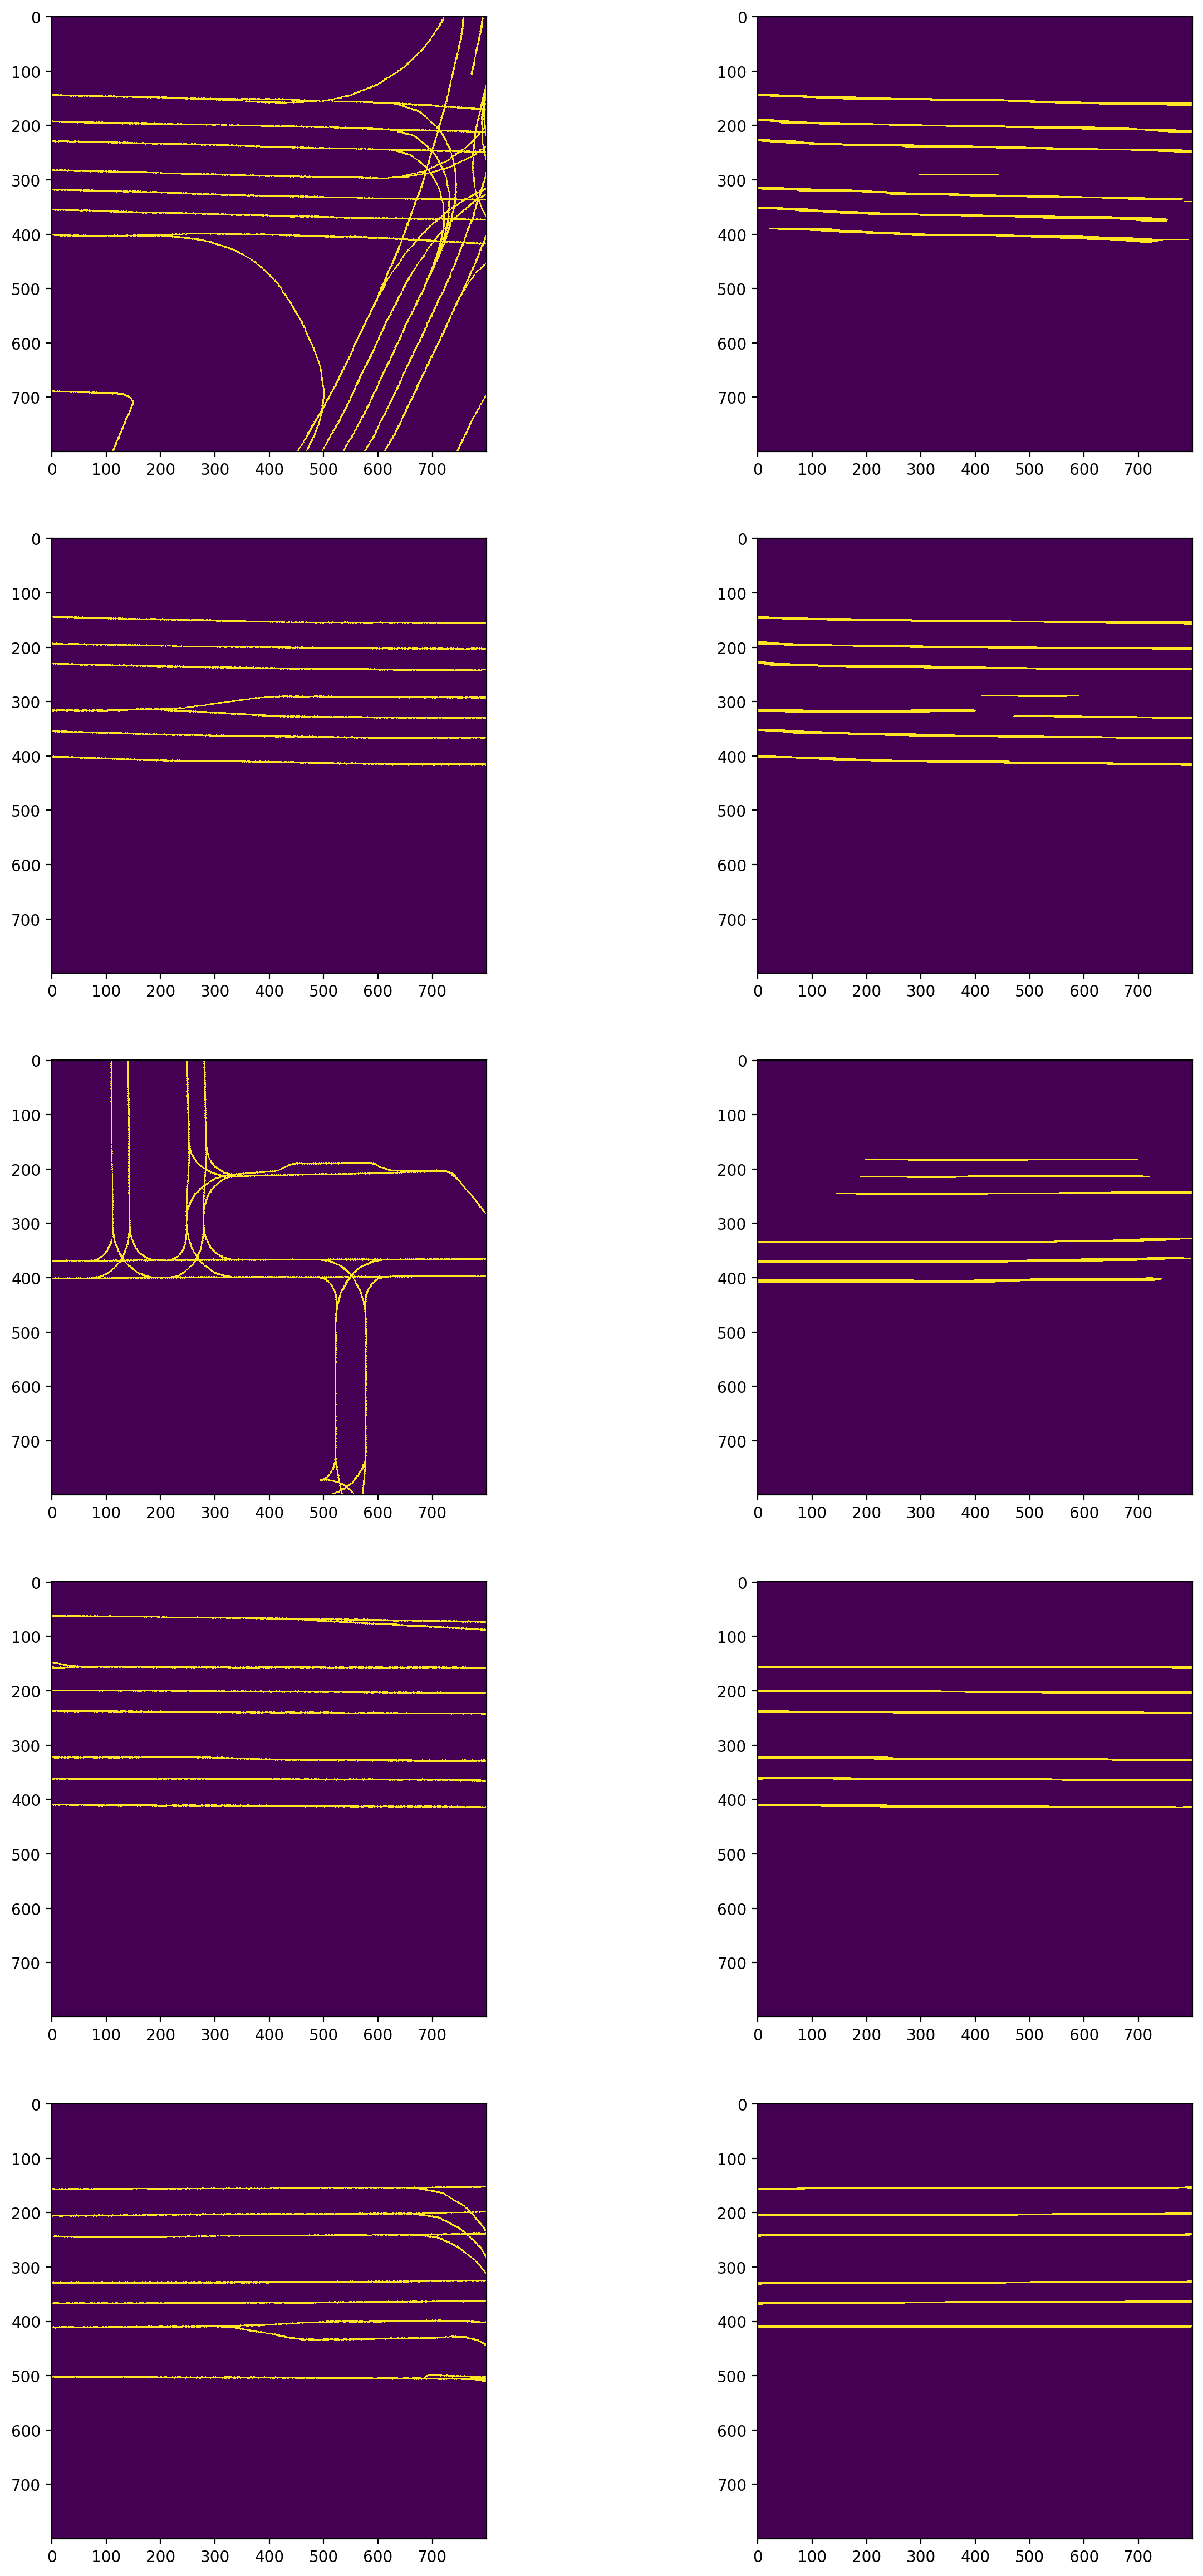

Epoch 12/30
----------
current epoch train composite loss is 1037.664407
training 1 epoch takes 197.010643
current epoch val composite loss is 254.568146
valing 1 epoch takes 216.734982
Epoch 13/30
----------
current epoch train composite loss is 1025.008843
training 1 epoch takes 184.766495
current epoch val composite loss is 255.215744
valing 1 epoch takes 207.392253
Epoch 14/30
----------
current epoch train composite loss is 1010.892686
training 1 epoch takes 210.318191
current epoch val composite loss is 236.747616
valing 1 epoch takes 232.657798
saving best model
Epoch 15/30
----------
current epoch train composite loss is 999.951147
training 1 epoch takes 193.344987
current epoch val composite loss is 262.242481
valing 1 epoch takes 211.846502
Epoch 16/30
----------
current epoch train composite loss is 991.088522
training 1 epoch takes 220.818267
current epoch val composite loss is 260.820794
valing 1 epoch takes 239.853314
Epoch 17/30
----------
current epoch train composite l

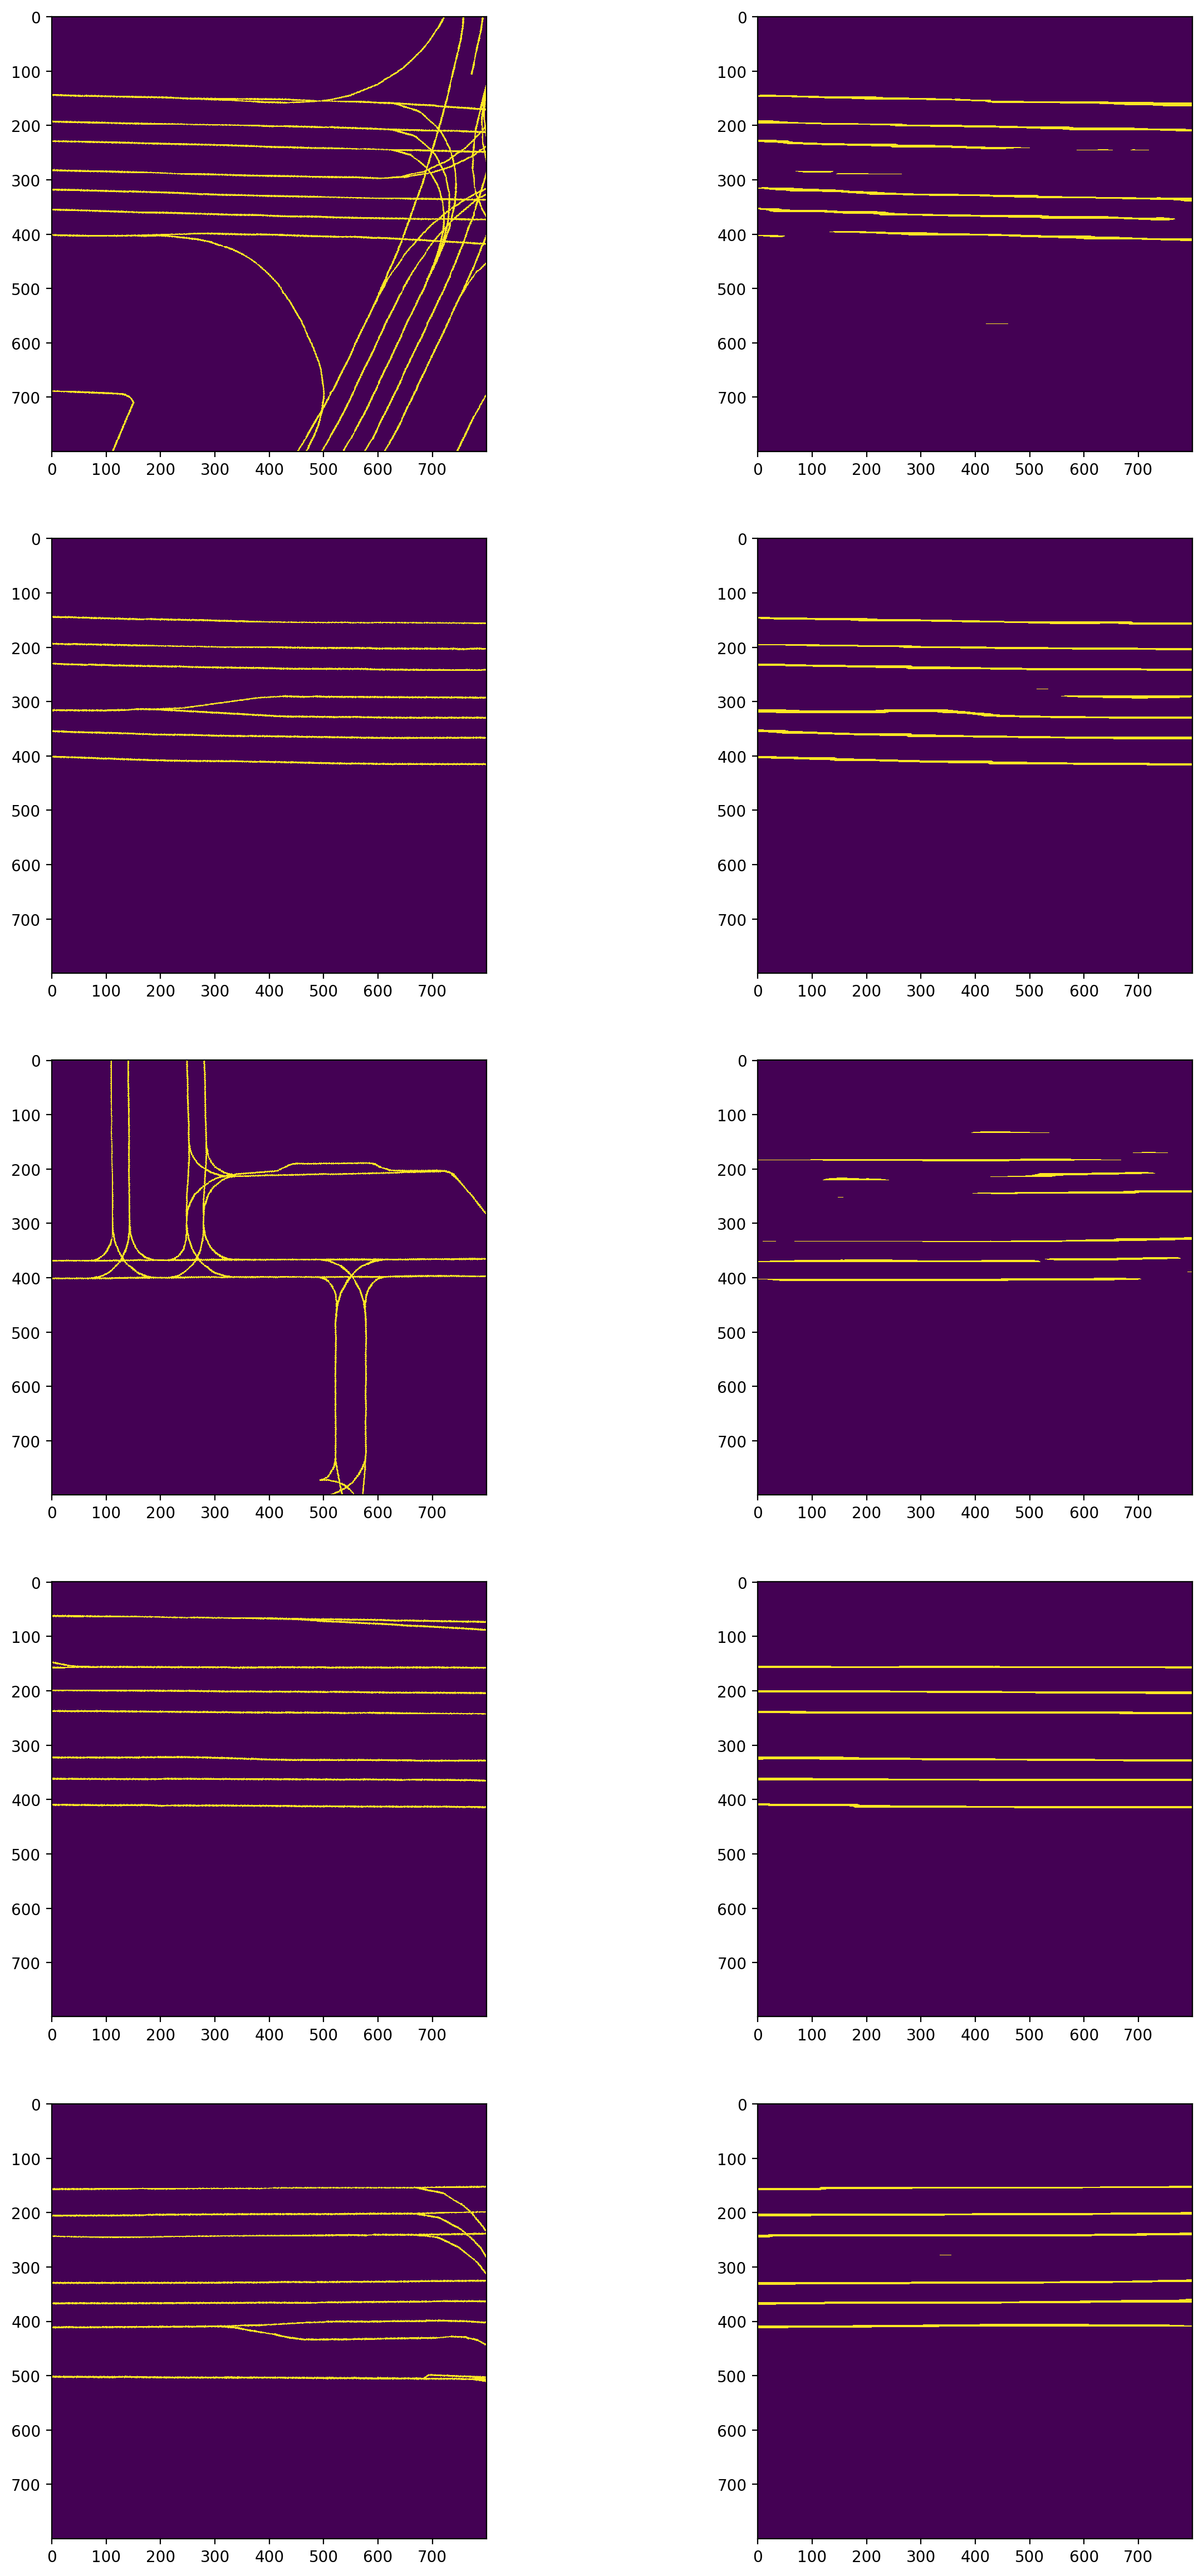

Epoch 22/30
----------
current epoch train composite loss is 936.481384
training 1 epoch takes 234.258630
current epoch val composite loss is 253.121905
valing 1 epoch takes 257.680250
Epoch 23/30
----------
current epoch train composite loss is 930.726206
training 1 epoch takes 184.650707
current epoch val composite loss is 235.750256
valing 1 epoch takes 203.965835
saving best model
Epoch 24/30
----------
current epoch train composite loss is 924.680528
training 1 epoch takes 191.936134
current epoch val composite loss is 251.595755
valing 1 epoch takes 210.503971
Epoch 25/30
----------
current epoch train composite loss is 917.511285
training 1 epoch takes 180.107441
current epoch val composite loss is 245.920699
valing 1 epoch takes 200.405705
Epoch 26/30
----------
current epoch train composite loss is 912.994732
training 1 epoch takes 216.231942
current epoch val composite loss is 254.145098
valing 1 epoch takes 234.461750
Epoch 27/30
----------
current epoch train composite loss

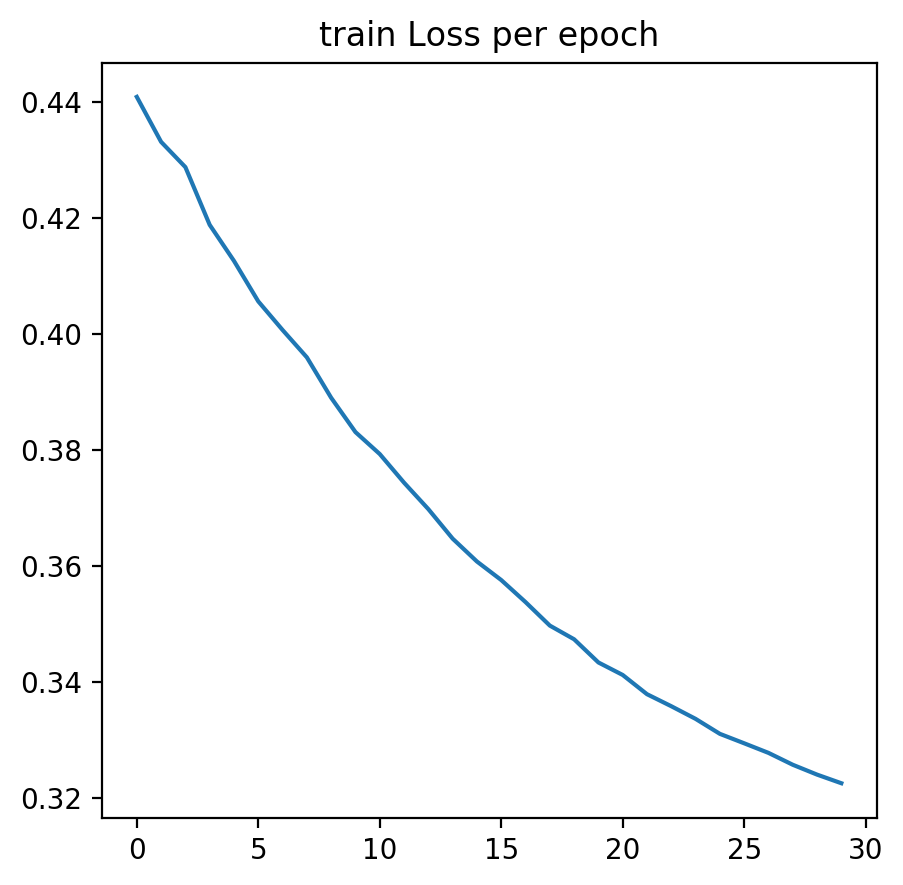

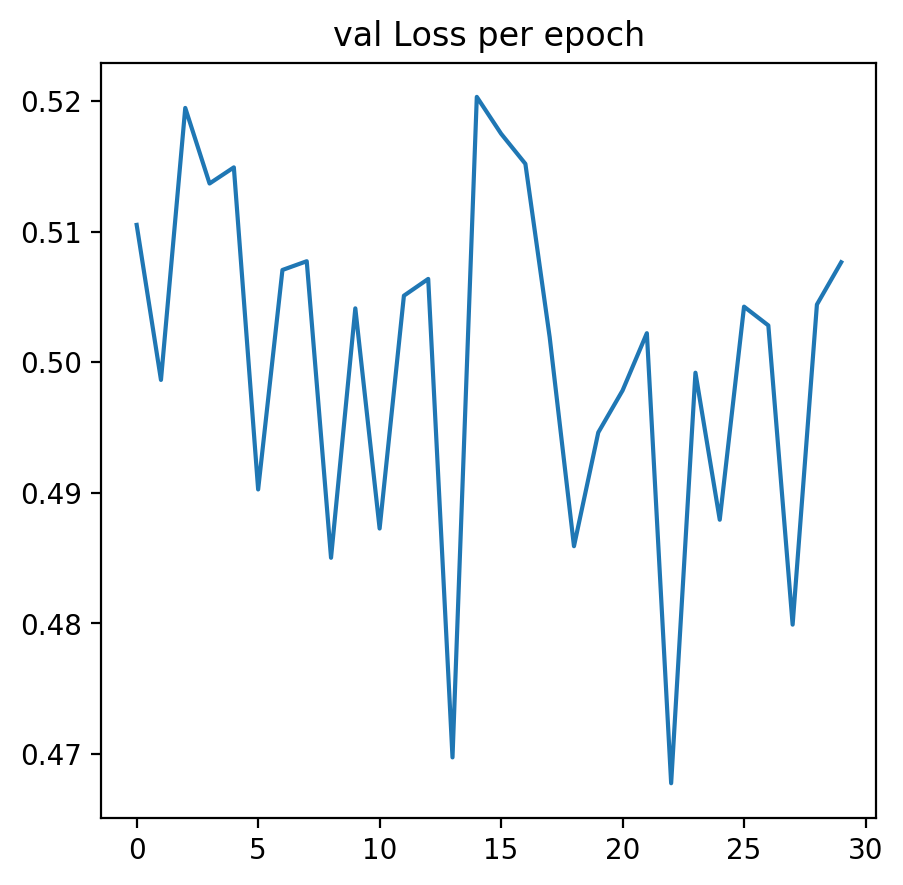

In [60]:
my_model = vae_mapping().cuda()
# optimizer = torch.optim.SGD(my_model.parameters(), lr = 1e-2, momentum=0.9)
# #optimizer2 = torch.optim.Adam(my_model.parameters(), lr=1e-4)
# model, loss_dict = train_eval_model(my_model,dataloaders,loss_function, optimizer, 
#                 num_epochs=30, checkpoint='/scratch/ht1162/DLResult/vae_pretrain_lane.pth', to_save = '/scratch/ht1162/DLResult/vae_pretrain_lane2.pth', 
#                                     print_every=10, eval_every = 1, to_eval = True )